#### The Data

You are provided with a sales dataset to use. A summary and preview are provided below.

#### Online Retail.csv

| Column     | Description              |
|------------|--------------------------|
| `'InvoiceNo'` | A 6-digit number uniquely assigned to each transaction |
| `'StockCode'` | A 5-digit number uniquely assigned to each distinct product |
| `'Description'` | The product name |
| `'Quantity'` | The quantity of each product (item) per transaction |
| `'UnitPrice'` | Product price per unit |
| `'CustomerID'` | A 5-digit number uniquely assigned to each customer |
| `'Country'` | The name of the country where each customer resides |
| `'InvoiceDate'` | The day and time when each transaction was generated `"MM/DD/YYYY"` |
| `'Year'` | The year when each transaction was generated |
| `'Month'` | The month when each transaction was generated |
| `'Week'` | The week when each transaction was generated (`1`-`52`) |
| `'Day'` | The day of the month when each transaction was generated (`1`-`31`) |
| `'DayOfWeek'` | The day of the weeke when each transaction was generated <br>(`0` = Monday, `6` = Sunday) |

In [2]:
# Import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as F
from pyspark.sql.functions import (
    col, dayofmonth, month, year, to_date, to_timestamp,
    weekofyear, dayofweek, lag, coalesce, lit, round as spark_round
)
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, LinearRegression, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
sns.set_context("talk")

In [3]:
spark = SparkSession.builder \
    .appName("SalesForecast") \
    .master("local[*]") \
    .config("spark.ui.showConsoleProgress", "false") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"Spark version: {spark.version}")

#local[*] = Use all available cores
#shuffle.partitions=8 = reasonable for small-to-medium datasets (adjust if your data is very large)
#driver.memory=4g = fine for most portfolio projects; increase if you get OOM errors

Spark version: 3.5.1


In [4]:
# Make sure to upload your kaggle.json file to your working directory
# On a local machine, place it in the ~/.kaggle/ directory.

# Download the dataset
#!kaggle datasets download -d tunguz/online-retail/ -f Online_Retail.csv --force

# Importing sales data
sales_data = spark.read.csv(
    "Online_Retail.csv", header=True, inferSchema=True, sep=",")

# Convert InvoiceDate to datetime 
sales_data = sales_data.withColumn("InvoiceDate", to_date(
    to_timestamp(col("InvoiceDate"), "M/d/yy H:mm")))

In [5]:
# View of the first 5 rows of the data
sales_data.show(5)

# To view the schema (data types) of the DataFrame
sales_data.printSchema()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
only showing top 5 rows

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nulla

In [6]:
# Total rows
total_rows = sales_data.count()

# Unique rows (based on ALL columns)
unique_rows = sales_data.distinct().count()

# Number of duplicates
duplicates = total_rows - unique_rows

print(f"Total rows: {total_rows}")
print(f"Unique rows: {unique_rows}")
print(f"Duplicate rows: {duplicates}")

Total rows: 541909
Unique rows: 536640
Duplicate rows: 5269


In [7]:
# Keep only unique rows
sales_data_clean = sales_data.dropDuplicates()

print(f"Before: {sales_data.count()} rows")
print(f"After: {sales_data_clean.count()} rows")
print(f"Removed: {sales_data.count() - sales_data_clean.count()} duplicates")

Before: 541909 rows
After: 536640 rows
Removed: 5269 duplicates


In [8]:
# Add basic calendar features from InvoiceDate for later analysis and modeling
sales_data_clean = (
    sales_data_clean
    .withColumn("Year", year(col("InvoiceDate")))          # Calendar year (e.g. 2010, 2011)
    .withColumn("Month", month(col("InvoiceDate")))        # Month number (1–12)
    .withColumn("Week", weekofyear(col("InvoiceDate")))    # Week number in the year
    .withColumn("Day", dayofmonth(col("InvoiceDate")))     # Day of month
    .withColumn("DayOfWeek", dayofweek(col("InvoiceDate")))  # 1=Sunday, ..., 7=Saturday
)

# Check a small sample to verify the new calendar columns
sales_data_clean.select(
    "InvoiceNo", "InvoiceDate", "Year", "Month", "Week", "Day", "DayOfWeek"
).show(5, truncate=False)

+---------+-----------+----+-----+----+---+---------+
|InvoiceNo|InvoiceDate|Year|Month|Week|Day|DayOfWeek|
+---------+-----------+----+-----+----+---+---------+
|536365   |2010-12-01 |2010|12   |48  |1  |4        |
|536365   |2010-12-01 |2010|12   |48  |1  |4        |
|536365   |2010-12-01 |2010|12   |48  |1  |4        |
|536367   |2010-12-01 |2010|12   |48  |1  |4        |
|536367   |2010-12-01 |2010|12   |48  |1  |4        |
+---------+-----------+----+-----+----+---+---------+
only showing top 5 rows



In [9]:
# Explore date range and invoice distribution by year/month

date_ranges = (
    sales_data_clean
    .groupBy("Year", "Month")
    .agg(
        F.min("InvoiceNo").alias("MinInvoice"),      # First invoice number in period
        F.max("InvoiceNo").alias("MaxInvoice"),      # Last invoice number in period
        F.min("InvoiceDate").alias("MinDate"),       # Earliest date in period
        F.max("InvoiceDate").alias("MaxDate"),       # Latest date in period
        F.count("*").alias("RecordCount")            # Number of records
    )
    .orderBy("Year", "Month")
)

date_ranges.show(50, truncate=False)  # Display full date range summary

+----+-----+----------+----------+----------+----------+-----------+
|Year|Month|MinInvoice|MaxInvoice|MinDate   |MaxDate   |RecordCount|
+----+-----+----------+----------+----------+----------+-----------+
|2010|12   |536365    |C539983   |2010-12-01|2010-12-23|41981      |
|2011|1    |539993    |C542753   |2011-01-04|2011-01-31|34900      |
|2011|2    |542776    |C545189   |2011-02-01|2011-02-28|27479      |
|2011|3    |545220    |C548543   |2011-03-01|2011-03-31|36439      |
|2011|4    |548550    |C551513   |2011-04-01|2011-04-28|29701      |
|2011|5    |551515    |C555105   |2011-05-01|2011-05-31|36782      |
|2011|6    |555156    |C558615   |2011-06-01|2011-06-30|36609      |
|2011|7    |558638    |C561886   |2011-07-01|2011-07-31|39267      |
|2011|8    |561904    |C565078   |2011-08-01|2011-08-31|35064      |
|2011|9    |565080    |C569138   |2011-09-01|2011-09-30|49860      |
|2011|10   |569203    |C573575   |2011-10-02|2011-10-31|59969      |
|2011|11   |573744    |C579887   |

In [10]:
# Calculate line-level revenue (quantity * unit price)
sales_data_clean = sales_data_clean.withColumn(
    "LineRevenue",
    F.col("Quantity") * F.col("UnitPrice")
)

# Aggregate to daily level: one row per Country x StockCode x Date
daily_sales = (
    sales_data_clean
    .groupBy(
        "Country",
        "StockCode",
        "InvoiceDate",
        "Year",
        "Month",
        "Day",
        "Week",
        "DayOfWeek"
    )
    .agg(
        F.sum("Quantity").alias("NetDailyQuantity"),                # Total quantity (includes returns as negative)
        F.round(F.sum("LineRevenue"), 2).alias("NetDailyRevenue"),  # Total revenue for the day
        F.round(F.avg("UnitPrice"), 2).alias("AvgUnitPrice")        # Average unit price
    )
)

daily_sales.show(5, truncate=False)

+--------------+---------+-----------+----+-----+---+----+---------+----------------+---------------+------------+
|Country       |StockCode|InvoiceDate|Year|Month|Day|Week|DayOfWeek|NetDailyQuantity|NetDailyRevenue|AvgUnitPrice|
+--------------+---------+-----------+----+-----+---+----+---------+----------------+---------------+------------+
|United Kingdom|22752    |2010-12-01 |2010|12   |1  |48  |4        |22              |178.5          |8.03        |
|France        |22631    |2010-12-01 |2010|12   |1  |48  |4        |24              |46.8           |1.95        |
|United Kingdom|85123A   |2010-12-01 |2010|12   |1  |48  |4        |454             |1224.18        |3.09        |
|United Kingdom|20679    |2010-12-01 |2010|12   |1  |48  |4        |37              |196.15         |5.28        |
|United Kingdom|85071B   |2010-12-01 |2010|12   |1  |48  |4        |96              |36.48          |0.38        |
+--------------+---------+-----------+----+-----+---+----+---------+------------

In [11]:
# Set global plotting style (clean, consistent visuals) 

plt.style.use("seaborn-v0_8-darkgrid")  # Dark grid background, good contrast
sns.set_palette("Spectral")                 # Distinct, colorful palette for multiple lines/bars
sns.set_context("notebook")                 # Slightly larger fonts, good for presentations/portfolio

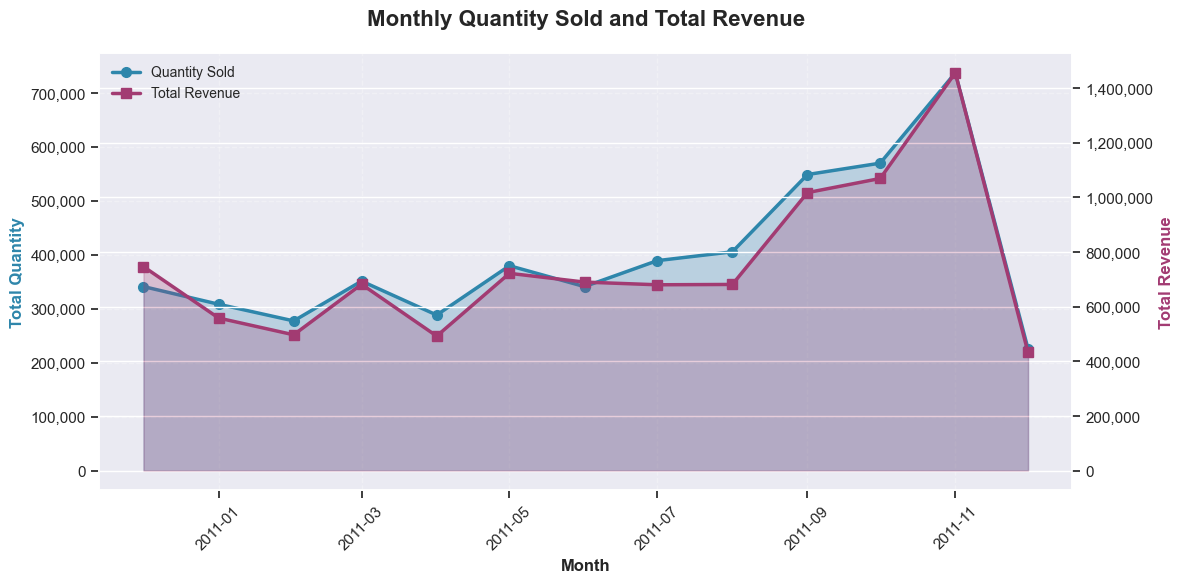

In [12]:
# Aggregate monthly quantity
monthly_qty = (
    daily_sales
    .groupBy("Year", "Month")
    .agg(F.sum("NetDailyQuantity").alias("TotalQuantity"))
    .orderBy("Year", "Month")
)

pdf_monthly_qty = monthly_qty.toPandas()
pdf_monthly_qty['Date'] = pd.to_datetime(
    pdf_monthly_qty['Year'].astype(str) + '-' + 
    pdf_monthly_qty['Month'].astype(str) + '-01'
)

# Aggregate monthly revenue
monthly_revenue = (
    daily_sales
    .groupBy("Year", "Month")
    .agg(F.sum("NetDailyRevenue").alias("TotalRevenue"))
    .orderBy("Year", "Month")
)

pdf_monthly_revenue = monthly_revenue.toPandas()
pdf_monthly_revenue['Date'] = pd.to_datetime(
    pdf_monthly_revenue['Year'].astype(str) + '-' + 
    pdf_monthly_revenue['Month'].astype(str) + '-01'
)

# Plot monthly quantity and revenue on dual-axis chart
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

# Quantity on left axis
ax1.plot(
    pdf_monthly_qty['Date'], pdf_monthly_qty['TotalQuantity'],
    marker='o', linewidth=2.5, markersize=7, color='#2E86AB', label='Quantity Sold'
)
ax1.fill_between(
    pdf_monthly_qty['Date'], pdf_monthly_qty['TotalQuantity'],
    alpha=0.25, color='#2E86AB'
)

# Revenue on right axis
ax2.plot(
    pdf_monthly_revenue['Date'], pdf_monthly_revenue['TotalRevenue'],
    marker='s', linewidth=2.5, markersize=7, color='#A23B72', label='Total Revenue'
)
ax2.fill_between(
    pdf_monthly_revenue['Date'], pdf_monthly_revenue['TotalRevenue'],
    alpha=0.25, color='#A23B72'
)

ax1.set_title('Monthly Quantity Sold and Total Revenue', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Month', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Quantity', fontsize=12, fontweight='bold', color='#2E86AB')
ax2.set_ylabel('Total Revenue', fontsize=12, fontweight='bold', color='#A23B72')

ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('monthly_quantity_revenue.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

#### Observation: Incomplete Data for December 2011

The `date_ranges` summary reveals that the dataset for December 2011 only extends until the 9th of the month (`MaxDate: 2011-12-09`). This partial data for December 2011 explains the apparent sharp drop in `RecordCount` and will naturally lead to a lower `TotalQuantity` and `TotalRevenue` for that month in any aggregated views.

This is a critical point for time series forecasting:
- **Data Truncation:** The last month is incomplete, which means it cannot be directly compared to full months.
- **Forecasting Horizon:** Any forecast model trained on this data will effectively have its "end date" around early December 2011. We cannot reliably forecast beyond this point without more recent data.
- **Evaluation Impact:** When evaluating models, we must be mindful that December 2011 is not a full month and should be treated carefully (e.g., excluded from full-month comparisons or used only for very short-term forecasts within its available range).

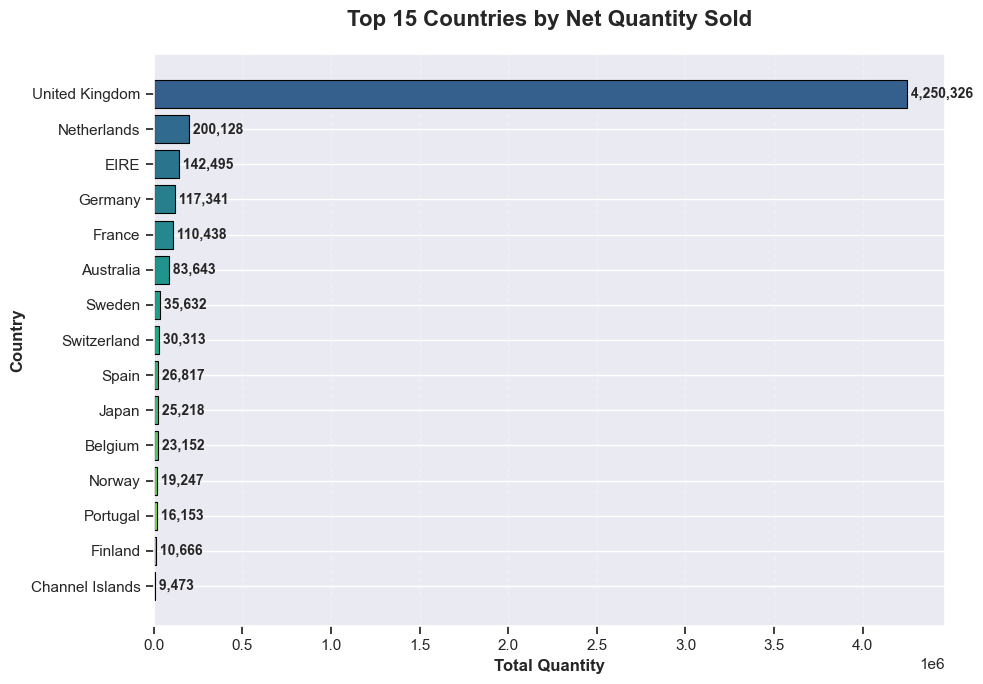

In [13]:
# Aggregate total quantity by country
country_qty = (
    daily_sales
    .groupBy("Country")
    .agg(F.sum("NetDailyQuantity").alias("TotalQuantity"))
    .orderBy(col("TotalQuantity").desc())
)

pdf_country = country_qty.toPandas()
pdf_country_top15 = pdf_country.head(15)

# Plot top 15 countries as horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 7))

bars = ax.barh(
    range(len(pdf_country_top15)),
    pdf_country_top15["TotalQuantity"],
    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(pdf_country_top15))),
    edgecolor="black",
    linewidth=0.8
)

ax.set_yticks(range(len(pdf_country_top15)))
ax.set_yticklabels(pdf_country_top15["Country"], fontsize=11)
ax.invert_yaxis()

ax.set_title("Top 15 Countries by Net Quantity Sold", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Total Quantity", fontsize=12, fontweight="bold")
ax.set_ylabel("Country", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, linestyle="--", axis="x")

# Add value labels to the right of each bar
for i, (bar, val) in enumerate(zip(bars, pdf_country_top15["TotalQuantity"])):
    ax.text(val, i, f" {int(val):,}", va="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.savefig("top15_countries_quantity.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

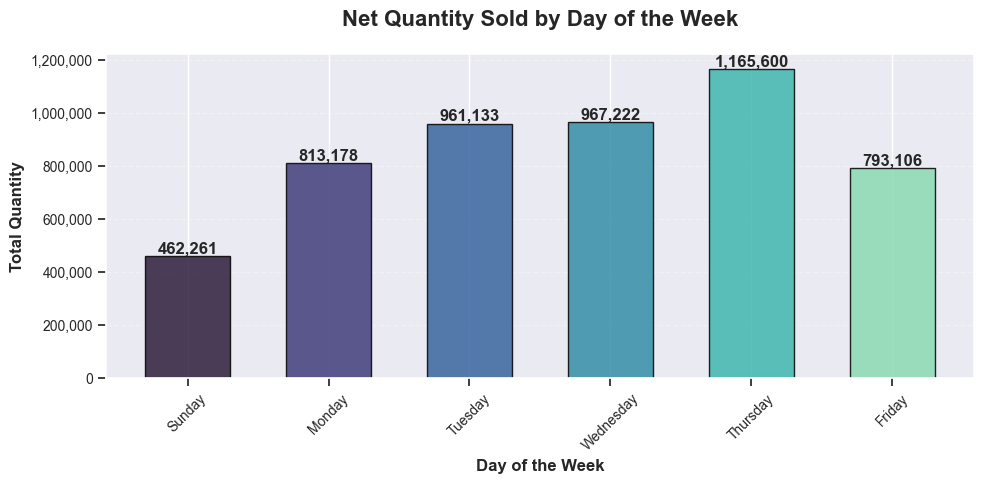

In [14]:
# Aggregate net quantity by day of week
dow_qty = (
    daily_sales
    .groupBy("DayOfWeek")
    .agg(F.sum("NetDailyQuantity").alias("TotalQuantity"))
    .orderBy("DayOfWeek")
)

pdf_dow = dow_qty.toPandas()

# Map Spark day numbers to day names (1=Sunday, ..., 7=Saturday)
dow_names = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}
pdf_dow["DayName"] = pdf_dow["DayOfWeek"].map(dow_names)

# Plot total quantity by day of week
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(
    pdf_dow["DayName"],
    pdf_dow["TotalQuantity"],
    width=0.6,
    color=sns.color_palette("mako", len(pdf_dow)),
    edgecolor="black",
    linewidth=1.0,
    alpha=0.85
)

ax.set_title("Net Quantity Sold by Day of the Week", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Day of the Week", fontsize=12, fontweight="bold")
ax.set_ylabel("Total Quantity", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, linestyle="--", axis="y")
ax.tick_params(axis="x", rotation=45, labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x):,}"))

# Add value labels on top of each bar
for bar, val in zip(bars, pdf_dow["TotalQuantity"]):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{int(val):,}",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

plt.tight_layout()
plt.savefig("quantity_by_day_of_week.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

In [15]:
# Apply log transformation to the target for potential modeling use
daily_sales_log = daily_sales.withColumn(
    "LogNetDailyQuantity",
    F.log1p("NetDailyQuantity")
)

# Time-based train/test split using InvoiceDate
split_date = "2011-09-01"

train_data = daily_sales.filter(col("InvoiceDate") <= split_date)
test_data = daily_sales.filter(col("InvoiceDate") > split_date)

# Check how the data is distributed between train and test
train_count = train_data.count()
test_count = test_data.count()
total_count = daily_sales.count()

print(f"Train rows: {train_count} ({train_count / total_count:.0%} of dataset)")
print(f"Test rows:  {test_count} ({test_count / total_count:.0%} of dataset)")

# Convert to pandas for series-level exploration and plotting
pd_daily_train = train_data.select(
    "Country", "StockCode", "InvoiceDate", "NetDailyQuantity", "NetDailyRevenue"
).toPandas()

pd_daily_test = test_data.select(
    "Country", "StockCode", "InvoiceDate", "NetDailyQuantity", "NetDailyRevenue"
).toPandas()

Train rows: 197016 (64% of dataset)
Test rows:  112999 (36% of dataset)


In [16]:
# Encode categorical variables
country_indexer = StringIndexer(
    inputCol="Country",
    outputCol="CountryIndex",
    handleInvalid="keep"  # Keep unseen categories instead of failing
)

stockcode_indexer = StringIndexer(
    inputCol="StockCode",
    outputCol="StockCodeIndex",
    handleInvalid="keep"
)

# Define input features for the model
feature_columns = [
    "CountryIndex",
    "StockCodeIndex",
    "Year",
    "Month",
    "Day",
    "Week",
    "DayOfWeek"
]

# Assemble all feature columns into a single vector
assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol="features",
    handleInvalid="skip"
)

# Baseline Random Forest regressor
rf_v1 = RandomForestRegressor(
    featuresCol="features",
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    seed=42,
    numTrees=50,
    maxDepth=5,
    maxBins=10000
)

# Build pipeline: indexing → assembling → model
pipeline_rf_v1 = Pipeline(stages=[
    country_indexer,
    stockcode_indexer,
    assembler,
    rf_v1
])

# Fit model on training data
model_rf_v1 = pipeline_rf_v1.fit(train_data)

# Generate predictions on test data
test_predictions_rf_v1 = model_rf_v1.transform(test_data)

# Inspect a few predictions
test_predictions_rf_v1.select(
    "InvoiceDate", "StockCode", "Country", "NetDailyQuantity", "prediction"
).show(10, truncate=False)

# Evaluate model on test set with multiple metrics
evaluator_mae = RegressionEvaluator(
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    metricName="mae"
)

evaluator_rmse = RegressionEvaluator(
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_r2 = RegressionEvaluator(
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    metricName="r2"
)

mae_rf_v1 = evaluator_mae.evaluate(test_predictions_rf_v1)
rmse_rf_v1 = evaluator_rmse.evaluate(test_predictions_rf_v1)
r2_rf_v1 = evaluator_r2.evaluate(test_predictions_rf_v1)

print("\nRandom Forest v1 - Test Set Performance")
print(f"MAE:  {mae_rf_v1:.2f}")
print(f"RMSE: {rmse_rf_v1:.2f}")
print(f"R²:   {r2_rf_v1:.4f}")

+-----------+---------+--------------+----------------+------------------+
|InvoiceDate|StockCode|Country       |NetDailyQuantity|prediction        |
+-----------+---------+--------------+----------------+------------------+
|2011-09-02 |21695    |United Kingdom|6               |51.61699263184821 |
|2011-09-02 |82494L   |United Kingdom|36              |15.068627567182002|
|2011-09-02 |22328    |United Kingdom|14              |11.946882498549316|
|2011-09-02 |23249    |United Kingdom|12              |12.806310345530417|
|2011-09-02 |22386    |United Kingdom|48              |48.053248327106246|
|2011-09-02 |22379    |United Kingdom|9               |15.03925076378818 |
|2011-09-02 |23206    |France        |10              |54.555491600088715|
|2011-09-02 |20728    |United Kingdom|40              |24.631876878427597|
|2011-09-02 |20724    |United Kingdom|50              |35.91355947791005 |
|2011-09-02 |85099B   |United Kingdom|152             |86.51852468648796 |
+-----------+---------+--

##### MAE (Mean Absolute Error)

- MAE measures the **average absolute difference** between the actual net daily quantity and the predicted value:
- Here, **MAE = 55.49** means that, on average, the model misses by about **55 units per (Country, StockCode, Day)**.
- Whether this is “good” or “bad” depends on the **scale** of `NetDailyQuantity`.  
  - For small products that sell 10–50 units a day, an error of ~55 units is very large.  
  - For very high-volume products, it might be more acceptable.

  we see **some small errors** (e.g., 14 vs 11.94) but also **very large errors** (e.g., 6 vs 51.62).  
  Those large errors strongly impact the overall metrics.

##### RMSE (Root Mean Squared Error)

- RMSE is similar to MAE but **penalizes large errors more strongly** (squaring the residuals):
- Here, **RMSE = 156.04**, which is much larger than the MAE.
- The fact that RMSE >> MAE suggests that there are **some very large mistakes** on certain days/products (outliers), which pull RMSE up.
- In practice, this means `rf_v1` struggles particularly with **high-volume days or volatile series**.

##### R² (Coefficient of Determination)

- R² measures how much of the **variance** in the target variable is explained by the model:
- A value of:
  - **1.0** → perfect predictions  
  - **0.0** → model is as good as predicting the mean of the target  
  - **< 0** → model is **worse than a naive “predict the mean” baseline**

- Here, **R² = -3.5010**, which is **strongly negative**.  
  This indicates that `rf_v1` is performing **worse than a baseline that simply predicts the average net daily quantity for all observations**.

##### What these results tell us

- The model **captures some patterns** (small errors on some products/days), but:
  - It is **not yet a good global forecaster** across all `(Country, StockCode, Day)` combinations.
  - It performs particularly poorly on **high-volume or highly variable series**, leading to a high RMSE and a negative R².

In [17]:
# Aggregate actual daily total quantity across all countries and products
actual_daily = (
    daily_sales
    .groupBy("InvoiceDate")
    .agg(F.sum("NetDailyQuantity").alias("ActualQty"))
)

# Aggregate predicted daily total quantity for the test period
pred_daily = (
    test_predictions_rf_v1
    .groupBy("InvoiceDate")
    .agg(F.round(F.sum("prediction"), 0).alias("PredQty")) 
)

# Join actual and predicted quantities by date
ts_comparison = actual_daily.join(pred_daily, on="InvoiceDate", how="left")

# Flag rows as train (1) or test (0) based on the split date
ts_comparison = ts_comparison.withColumn(
    "Split",
    (col("InvoiceDate") <= lit(split_date)).cast("int")
)

# Convert to pandas for time series plotting and inspection
pdf_ts_comparison = ts_comparison.orderBy("InvoiceDate").toPandas()

# Inspect the last few days to verify the join and split flag
pdf_ts_comparison.tail(10)

,InvoiceDate,ActualQty,PredQty,Split
295,2011-11-29,30416,72330.0,0
296,2011-11-30,26450,74035.0,0
297,2011-12-01,26772,67695.0,0
298,2011-12-02,26845,75037.0,0
299,2011-12-04,12282,110140.0,0
300,2011-12-05,44038,172990.0,0
301,2011-12-06,28947,73605.0,0
302,2011-12-07,39521,72510.0,0
303,2011-12-08,34385,73810.0,0
304,2011-12-09,12919,55519.0,0


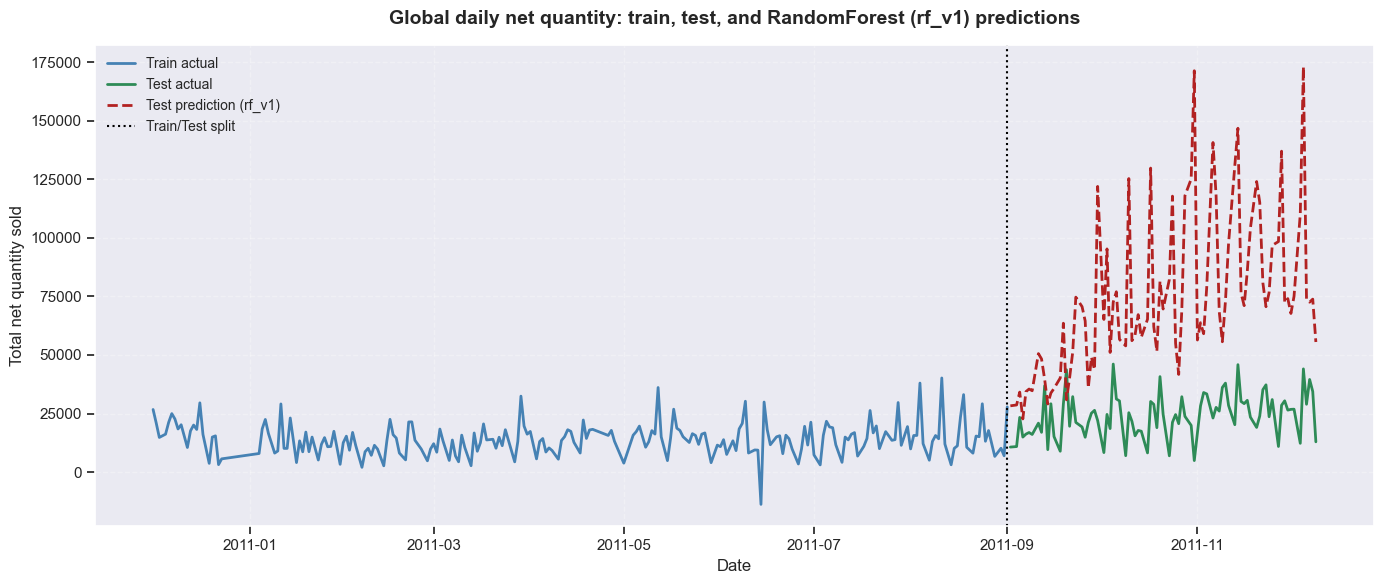

In [18]:
# Convert Spark DataFrame to pandas and create train/test masks
pdf = ts_comparison.orderBy("InvoiceDate").toPandas()
pdf["InvoiceDate"] = pd.to_datetime(pdf["InvoiceDate"])

train_mask = pdf["InvoiceDate"] <= pd.to_datetime(split_date)
test_mask = pdf["InvoiceDate"] > pd.to_datetime(split_date)

# Plot global daily net quantity for train, test, and model predictions
plt.figure(figsize=(14, 6))

# Actual values in the train period
plt.plot(
    pdf.loc[train_mask, "InvoiceDate"],
    pdf.loc[train_mask, "ActualQty"],
    label="Train actual",
    color="steelblue",
    linewidth=2
)

# Actual values in the test period
plt.plot(
    pdf.loc[test_mask, "InvoiceDate"],
    pdf.loc[test_mask, "ActualQty"],
    label="Test actual",
    color="seagreen",
    linewidth=2
)

# Predicted values in the test period
plt.plot(
    pdf.loc[test_mask, "InvoiceDate"],
    pdf.loc[test_mask, "PredQty"],
    label="Test prediction (rf_v1)",
    color="firebrick",
    linestyle="--",
    linewidth=2
)

# Vertical line marking the train/test split
plt.axvline(
    pd.to_datetime(split_date),
    color="black",
    linestyle=":",
    linewidth=1.5,
    label="Train/Test split"
)

plt.title(
    "Global daily net quantity: train, test, and RandomForest (rf_v1) predictions",
    fontsize=14,
    fontweight="bold",
    pad=15
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total net quantity sold", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

In [19]:
# Windows for time-based features
window_day = Window.partitionBy("Country", "StockCode").orderBy("InvoiceDate")
window_dow = Window.partitionBy("Country", "StockCode", "DayOfWeek").orderBy("InvoiceDate")

# Start with existing columns
all_cols = [F.col(c) for c in daily_sales.columns]

# Add lag features for recent days and 6‑day cycles (dataset has no Saturday)
for i in range(1, 7):
    # Daily lags: previous i days with data
    all_cols.append(
        F.round(F.coalesce(F.lag("NetDailyQuantity", i).over(window_day), F.lit(0)), 0)
        .alias(f"lag_quantity_{i}_day")
    )
    all_cols.append(
        F.round(F.coalesce(F.lag("AvgUnitPrice", i).over(window_day), F.lit(0)), 0)
        .alias(f"lag_price_{i}_day")
    )

    # 6‑day cycle lags: approximate “weekly” pattern (no Saturday in the data)
    offset = i * 6
    all_cols.append(
        F.round(F.coalesce(F.lag("NetDailyQuantity", offset).over(window_day), F.lit(0)), 0)
        .alias(f"lag_quantity_{i}_6daycycle")
    )
    all_cols.append(
        F.round(F.coalesce(F.lag("AvgUnitPrice", offset).over(window_day), F.lit(0)), 0)
        .alias(f"lag_price_{i}_6daycycle")
    )

    # Same day-of-week lags: last Monday, 2 Mondays ago, etc.
    all_cols.append(
        F.round(F.coalesce(F.lag("NetDailyQuantity", i).over(window_dow), F.lit(0)), 0)
        .alias(f"lag_quantity_{i}_dow")
    )
    all_cols.append(
        F.round(F.coalesce(F.lag("AvgUnitPrice", i).over(window_dow), F.lit(0)), 0)
        .alias(f"lag_price_{i}_dow")
    )

# Apply all transformations in a single select
daily_sales_v2 = daily_sales.select(all_cols)

# Cache the DataFrame since lag computation is expensive
daily_sales_v2.cache()
daily_sales_v2.count()  # Trigger the cache

# Inspect schema and a small sample of lag features
print("Schema of daily_sales_v2 with lag features:")
daily_sales_v2.printSchema()

sample_cols = [
    "InvoiceDate", "Country", "StockCode",
    "NetDailyQuantity", "NetDailyRevenue", "AvgUnitPrice", 
    "lag_quantity_1_day", "lag_price_1_day", 
    "lag_quantity_6_day", "lag_price_6_day", 
    "lag_quantity_1_6daycycle", "lag_price_1_6daycycle",
    "lag_quantity_1_dow", "lag_price_1_dow"
]

daily_sales_v2.select(sample_cols).show(10, truncate=False)

Schema of daily_sales_v2 with lag features:
root
 |-- Country: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- NetDailyQuantity: long (nullable = true)
 |-- NetDailyRevenue: double (nullable = true)
 |-- AvgUnitPrice: double (nullable = true)
 |-- lag_quantity_1_day: long (nullable = true)
 |-- lag_price_1_day: double (nullable = true)
 |-- lag_quantity_1_6daycycle: long (nullable = true)
 |-- lag_price_1_6daycycle: double (nullable = true)
 |-- lag_quantity_1_dow: long (nullable = true)
 |-- lag_price_1_dow: double (nullable = true)
 |-- lag_quantity_2_day: long (nullable = true)
 |-- lag_price_2_day: double (nullable = true)
 |-- lag_quantity_2_6daycycle: long (nullable = true)
 |-- lag_price_2_6daycycle: double (nullable = true)
 |--

In [20]:
# Train/test split based on date cutoff (using daily_sales_v2 with lag features)
split_date = "2011-09-01"

train_data_v2 = daily_sales_v2.filter(col("InvoiceDate") <= split_date)
test_data_v2 = daily_sales_v2.filter(col("InvoiceDate") > split_date)

# Check how the data is distributed between train and test
train_count_v2 = train_data_v2.count()
test_count_v2 = test_data_v2.count()
total_count_v2 = daily_sales_v2.count()

print(f"Train data (v2): {train_count_v2} rows ({train_count_v2 / total_count_v2:.0%} of dataset)")
print(f"Test data (v2):  {test_count_v2} rows ({test_count_v2 / total_count_v2:.0%} of dataset)")

Train data (v2): 197016 rows (64% of dataset)
Test data (v2):  112999 rows (36% of dataset)


In [21]:
# Encode categorical variables
country_indexer = StringIndexer(
    inputCol="Country",
    outputCol="CountryIndex",
    handleInvalid="keep"
)

stockcode_indexer = StringIndexer(
    inputCol="StockCode",
    outputCol="StockCodeIndex",
    handleInvalid="keep"
)

# Define base feature columns (calendar features + indexed categoricals)
feature_columns_v2 = [
    "CountryIndex",
    "StockCodeIndex",
    "Year",
    "Month",
    "Day",
    "Week",
    "DayOfWeek"
]

# Add all lag features (daily, 6-day cycle, and same day-of-week)
for i in range(1, 7):
    feature_columns_v2.extend([
        f"lag_quantity_{i}_day",
        f"lag_price_{i}_day",
        f"lag_quantity_{i}_6daycycle",
        f"lag_price_{i}_6daycycle",
        f"lag_quantity_{i}_dow",
        f"lag_price_{i}_dow"
    ])

# Assemble all feature columns into a single vector
assembler_v2 = VectorAssembler(
    inputCols=feature_columns_v2,
    outputCol="features",
    handleInvalid="skip"
)

# Random Forest regressor with lag features
rf_v2 = RandomForestRegressor(
    featuresCol="features",
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    seed=42,
    numTrees=50,
    maxDepth=5,
    maxBins=10000
)

# Build pipeline: indexing → assembling → model
pipeline_rf_v2 = Pipeline(stages=[
    country_indexer,
    stockcode_indexer,
    assembler_v2,
    rf_v2
])

print("rf_v2 pipeline ready with lag features (1-6 days and 6-day cycles)")

rf_v2 pipeline ready with lag features (1-6 days and 6-day cycles)


In [22]:
# Fit model on training data
model_rf_v2 = pipeline_rf_v2.fit(train_data_v2)

# Generate predictions on test data
test_predictions_rf_v2 = model_rf_v2.transform(test_data_v2)

# Evaluate model on test set with multiple metrics
mae_rf_v2 = evaluator_mae.evaluate(test_predictions_rf_v2)
rmse_rf_v2 = evaluator_rmse.evaluate(test_predictions_rf_v2)
r2_rf_v2 = evaluator_r2.evaluate(test_predictions_rf_v2)

print("\nRandom Forest v2 - Test Set Performance")
print(f"MAE:  {mae_rf_v2:.2f}")
print(f"RMSE: {rmse_rf_v2:.2f}")
print(f"R²:   {r2_rf_v2:.4f}")


Random Forest v2 - Test Set Performance
MAE:  45.85
RMSE: 121.45
R²:   -1.7267


##### Performance of model `rf_v2`

With the inclusion of lag features, model `rf_v2` now makes **smaller errors per individual observation**, both on average and for the more extreme cases. In other words, for each `(Country, StockCode, Day)` combination, the predictions are closer to the actual values.

On the other hand, the **R² is still negative**, which means that, when looking at the dataset as a whole (especially at globally aggregated daily totals), the model still does not explain the variability well and remains worse than a simple baseline.

In summary: we **improved point‑by‑point accuracy**, but we still need to improve the model's ability to **capture the global structure of the series**, either with more features (moving averages, volatility, holidays) and/or additional model tuning.

In [23]:
# Define Linear Regression model
lr_v1 = LinearRegression(
    featuresCol="features",
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    maxIter=20,
    regParam=0.1,  # L2 regularization to prevent overfitting
    elasticNetParam=1.0,  # 0.0 = Ridge (L2), 1.0 = Lasso (L1)
    solver="auto",
    standardization=True,  # Standardize features before training
    fitIntercept=True
)

# Build pipeline: indexing → assembling → linear regression
pipeline_lr_v1 = Pipeline(stages=[
    country_indexer,
    stockcode_indexer,
    assembler_v2,
    lr_v1
])

# Fit model on training data
print("Training Linear Regression model with lag features...")
model_lr_v1 = pipeline_lr_v1.fit(train_data_v2)

# Generate predictions on test data
test_predictions_lr_v1 = model_lr_v1.transform(test_data_v2)

# Inspect a few predictions
print("\nSample predictions from Linear Regression v1:")
test_predictions_lr_v1.select(
    "InvoiceDate", "StockCode", "Country", "NetDailyQuantity", "prediction"
).show(10, truncate=False)

# Evaluate model on test set with multiple metrics
mae_lr_v1 = evaluator_mae.evaluate(test_predictions_lr_v1)
rmse_lr_v1 = evaluator_rmse.evaluate(test_predictions_lr_v1)
r2_lr_v1 = evaluator_r2.evaluate(test_predictions_lr_v1)

print("\nLinear Regression v1 - Test Set Performance")
print(f"MAE:  {mae_lr_v1:.2f}")
print(f"RMSE: {rmse_lr_v1:.2f}")
print(f"R²:   {r2_lr_v1:.4f}")

# Compare all models trained so far
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"Random Forest v1 (no lags):        MAE = {mae_rf_v1:.2f}  |  RMSE = {rmse_rf_v1:.2f}  |  R² = {r2_rf_v1:.4f}")
print(f"Random Forest v2 (with lags):      MAE = {mae_rf_v2:.2f}  |  RMSE = {rmse_rf_v2:.2f}  |  R² = {r2_rf_v2:.4f}")
print(f"Linear Regression v1 (with lags):  MAE = {mae_lr_v1:.2f}  |  RMSE = {rmse_lr_v1:.2f}  |  R² = {r2_lr_v1:.4f}")
print("="*70)

Training Linear Regression model with lag features...

Sample predictions from Linear Regression v1:
+-----------+---------+---------+----------------+------------------+
|InvoiceDate|StockCode|Country  |NetDailyQuantity|prediction        |
+-----------+---------+---------+----------------+------------------+
|2011-09-28 |20726    |Australia|30              |28.745955296423745|
|2011-09-28 |20728    |Australia|20              |22.83231431229615 |
|2011-09-16 |20749    |Australia|2               |22.320915932805292|
|2011-09-16 |20838    |Australia|12              |14.020896287629512|
|2011-09-28 |21058    |Australia|12              |23.37253677442186 |
|2011-10-05 |21115    |Australia|16              |18.63397491959313 |
|2011-09-28 |21198    |Australia|24              |16.859727457580448|
|2011-09-16 |21202    |Australia|12              |12.844639518695658|
|2011-09-16 |21208    |Australia|12              |17.16520912909982 |
|2011-10-05 |21539    |Australia|3               |20.562539

#### Linear Regression

Adding Linear Regression to the model comparison brought a **notable improvement** across all performance metrics.

- **MAE and RMSE dropped significantly**, indicating that the Linear Regression predictions are, on average, much closer to the actual values and have smaller error magnitudes.
- For the first time, the **R² became positive**, showing that this model is able to explain part of the variance in the data and outperform the simple mean-based baseline.

This suggests that, for this problem, Linear Regression with calendar and lag features is a **more effective approach** than the Random Forest models tested so far, offering a better balance between simplicity and predictive power.

In [24]:
# Define Gradient-Boosted Trees regressor
gbt_v1 = GBTRegressor(
    featuresCol="features",
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    maxIter=20,          # Number of boosting iterations (trees)
    maxDepth=3,          # Maximum depth of each tree
    stepSize=0.01,       # Learning rate
    maxBins=10000,
    lossType="absolute", # Closer to optimizing MAE
    seed=42
)

# Build pipeline: indexing → assembling → GBT
pipeline_gbt_v1 = Pipeline(stages=[
    country_indexer,
    stockcode_indexer,
    assembler_v2,
    gbt_v1
])

# Fit model on training data
print("Training Gradient-Boosted Trees model with lag features...")
model_gbt_v1 = pipeline_gbt_v1.fit(train_data_v2)

# Generate predictions on test data
test_predictions_gbt_v1 = model_gbt_v1.transform(test_data_v2)

# Inspect a few predictions
print("\nSample predictions from GBT v1:")
test_predictions_gbt_v1.select(
    "InvoiceDate", "StockCode", "Country", "NetDailyQuantity", "prediction"
).show(10, truncate=False)

# Evaluate model on test set with multiple metrics
mae_gbt_v1 = evaluator_mae.evaluate(test_predictions_gbt_v1)
rmse_gbt_v1 = evaluator_rmse.evaluate(test_predictions_gbt_v1)
r2_gbt_v1 = evaluator_r2.evaluate(test_predictions_gbt_v1)

print("\nGradient-Boosted Trees v1 - Test Set Performance")
print(f"MAE:  {mae_gbt_v1:.2f}")
print(f"RMSE: {rmse_gbt_v1:.2f}")
print(f"R²:   {r2_gbt_v1:.4f}")

# Compare all models trained so far
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"Random Forest v1 (no lags):             MAE = {mae_rf_v1:.2f}  |  RMSE = {rmse_rf_v1:.2f}  |  R² = {r2_rf_v1:.4f}")
print(f"Random Forest v2 (with lags):           MAE = {mae_rf_v2:.2f}  |  RMSE = {rmse_rf_v2:.2f}  |  R² = {r2_rf_v2:.4f}")
print(f"Linear Regression v1 (with lags):       MAE = {mae_lr_v1:.2f}  |  RMSE = {rmse_lr_v1:.2f}  |  R² = {r2_lr_v1:.4f}")
print(f"Gradient-Boosted Trees v1 (with lags):  MAE = {mae_gbt_v1:.2f}  |  RMSE = {rmse_gbt_v1:.2f}  |  R² = {r2_gbt_v1:.4f}")
print("="*70)

Training Gradient-Boosted Trees model with lag features...

Sample predictions from GBT v1:
+-----------+---------+---------+----------------+------------------+
|InvoiceDate|StockCode|Country  |NetDailyQuantity|prediction        |
+-----------+---------+---------+----------------+------------------+
|2011-09-28 |20726    |Australia|30              |11.061750103312516|
|2011-09-28 |20728    |Australia|20              |43.63900042168997 |
|2011-09-16 |20749    |Australia|2               |11.003036708444752|
|2011-09-16 |20838    |Australia|12              |11.041438995287994|
|2011-09-28 |21058    |Australia|12              |11.041438995287994|
|2011-10-05 |21115    |Australia|16              |11.003036708444752|
|2011-09-28 |21198    |Australia|24              |11.041438995287994|
|2011-09-16 |21202    |Australia|12              |11.041438995287994|
|2011-09-16 |21208    |Australia|12              |11.041438995287994|
|2011-10-05 |21539    |Australia|3               |11.003036708444752

#### GBTRegressor

The GBTRegressor model showed **intermediate performance**. Although it outperformed the Random Forest models in terms of MAE and RMSE, it **did not reach the performance of Linear Regression**.

The GBTRegressor's R² remained negative, indicating that, like Random Forest, it still does not explain the data variance more effectively than a simple baseline. This suggests that, for this dataset and feature set, **Linear Regression captured the underlying structure better**, while tree-based models may be struggling to generalize or are more affected by noise.

In [25]:
# Rolling window features by Product + Country (series-level)
df = daily_sales_v2

window_sizes_days = [3, 6, 12]

for w in window_sizes_days:
    # Window per (Country, StockCode) ordered by date, using only past rows
    w_series = (
        Window
        .partitionBy("Country", "StockCode")
        .orderBy("InvoiceDate")
        .rowsBetween(-w, -1)  # last w records before the current day
    )

    df = df.withColumn(
        f"roll_mean_{w}d",
        F.avg("NetDailyQuantity").over(w_series)
    ).withColumn(
        f"roll_std_{w}d",
        F.stddev_samp("NetDailyQuantity").over(w_series)
    ).withColumn(
        f"roll_median_{w}d",
        F.percentile_approx("NetDailyQuantity", 0.5).over(w_series)
    )

# Rolling window features by Product + Country + Day of Week (same weekday)
window_sizes_dow = [3, 4, 5]

for w in window_sizes_dow:
    # Window per (Country, StockCode, DayOfWeek) ordered by date, using only past rows
    w_dow = (
        Window
        .partitionBy("Country", "StockCode", "DayOfWeek")
        .orderBy("InvoiceDate")
        .rowsBetween(-w, -1)  # last w occurrences of this same weekday
    )

    df = df.withColumn(
        f"roll_mean_{w}_dow",
        F.avg("NetDailyQuantity").over(w_dow)
    ).withColumn(
        f"roll_std_{w}_dow",
        F.stddev_samp("NetDailyQuantity").over(w_dow)
    ).withColumn(
        f"roll_median_{w}_dow",
        F.percentile_approx("NetDailyQuantity", 0.5).over(w_dow)
    )

# Differences between current value and rolling mean/median (series-level)
for w in window_sizes_days:
    df = df.withColumn(
        f"diff_qty_mean_{w}d",
        F.col("NetDailyQuantity") - F.col(f"roll_mean_{w}d")
    ).withColumn(
        f"diff_qty_median_{w}d",
        F.col("NetDailyQuantity") - F.col(f"roll_median_{w}d")
    )

# Differences between current value and weekday-based rolling mean/median
for w in window_sizes_dow:
    df = df.withColumn(
        f"diff_qty_mean_{w}_dow",
        F.col("NetDailyQuantity") - F.col(f"roll_mean_{w}_dow")
    ).withColumn(
        f"diff_qty_median_{w}_dow",
        F.col("NetDailyQuantity") - F.col(f"roll_median_{w}_dow")
    )

# Fill nulls (early periods without enough history) with 0 for rolling features
rolling_cols = []
for w in window_sizes_days:
    rolling_cols.extend([
        f"roll_mean_{w}d", f"roll_std_{w}d", f"roll_median_{w}d",
        f"diff_qty_mean_{w}d", f"diff_qty_median_{w}d"
    ])

for w in window_sizes_dow:
    rolling_cols.extend([
        f"roll_mean_{w}_dow", f"roll_std_{w}_dow", f"roll_median_{w}_dow",
        f"diff_qty_mean_{w}_dow", f"diff_qty_median_{w}_dow"
    ])

df = df.fillna(0, subset=rolling_cols)

# Cache as this DataFrame will be used for modeling
df = df.cache()
df.count()

daily_sales_v3 = df

print("Schema of daily_sales_v3 with new rolling features:")
daily_sales_v3.printSchema()

# Prepare feature pipeline (v3) with calendar, lag, and rolling features
country_indexer_v3 = StringIndexer(
    inputCol="Country",
    outputCol="CountryIndex",
    handleInvalid="keep"
)

stockcode_indexer_v3 = StringIndexer(
    inputCol="StockCode",
    outputCol="StockCodeIndex",
    handleInvalid="keep"
)

feature_columns_v3 = [
    "CountryIndex",
    "StockCodeIndex",
    "Year",
    "Month",
    "Day",
    "Week",
    "DayOfWeek",

    # Existing lag features (quantity, price, ratio)
    "lag_quantity_1_day", "lag_price_1_day", 
    "lag_quantity_1_6daycycle", "lag_price_1_6daycycle",
    "lag_quantity_1_dow",  "lag_price_1_dow",

    "lag_quantity_2_day", "lag_price_2_day", 
    "lag_quantity_2_6daycycle", "lag_price_2_6daycycle",
    "lag_quantity_2_dow",  "lag_price_2_dow",

    "lag_quantity_3_day", "lag_price_3_day", 
    "lag_quantity_3_6daycycle", "lag_price_3_6daycycle",
    "lag_quantity_3_dow",  "lag_price_3_dow",

    "lag_quantity_4_day", "lag_price_4_day", 
    "lag_quantity_4_6daycycle", "lag_price_4_6daycycle",
    "lag_quantity_4_dow",  "lag_price_4_dow",

    "lag_quantity_5_day", "lag_price_5_day", 
    "lag_quantity_5_6daycycle", "lag_price_5_6daycycle",
    "lag_quantity_5_dow",  "lag_price_5_dow",

    "lag_quantity_6_day", "lag_price_6_day", 
    "lag_quantity_6_6daycycle", "lag_price_6_6daycycle",
    "lag_quantity_6_dow",  "lag_price_6_dow",

    # Rolling stats by series (3, 6, 12 days)
    "roll_mean_3d", "roll_std_3d", "roll_median_3d",
    "roll_mean_6d", "roll_std_6d", "roll_median_6d",
    "roll_mean_12d", "roll_std_12d", "roll_median_12d",

    # Rolling stats by series + weekday (3, 4, 5 occurrences)
    "roll_mean_3_dow", "roll_std_3_dow", "roll_median_3_dow",
    "roll_mean_4_dow", "roll_std_4_dow", "roll_median_4_dow",
    "roll_mean_5_dow", "roll_std_5_dow", "roll_median_5_dow",

    # Differences vs series-based rolling windows
    "diff_qty_mean_3d", "diff_qty_median_3d",
    "diff_qty_mean_6d", "diff_qty_median_6d",
    "diff_qty_mean_12d", "diff_qty_median_12d",

    # Differences vs weekday-based rolling windows
    "diff_qty_mean_3_dow", "diff_qty_median_3_dow",
    "diff_qty_mean_4_dow", "diff_qty_median_4_dow",
    "diff_qty_mean_5_dow", "diff_qty_median_5_dow",
]

assembler_v3 = VectorAssembler(
    inputCols=feature_columns_v3,
    outputCol="features",
    handleInvalid="skip"
)

pipeline_features_v3 = Pipeline(stages=[
    country_indexer_v3,
    stockcode_indexer_v3,
    assembler_v3
])

print("pipeline_features_v3 created (indexing + vectorization with lags and rolling stats)")

Schema of daily_sales_v3 with new rolling features:
root
 |-- Country: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- NetDailyQuantity: long (nullable = true)
 |-- NetDailyRevenue: double (nullable = true)
 |-- AvgUnitPrice: double (nullable = true)
 |-- lag_quantity_1_day: long (nullable = true)
 |-- lag_price_1_day: double (nullable = true)
 |-- lag_quantity_1_6daycycle: long (nullable = true)
 |-- lag_price_1_6daycycle: double (nullable = true)
 |-- lag_quantity_1_dow: long (nullable = true)
 |-- lag_price_1_dow: double (nullable = true)
 |-- lag_quantity_2_day: long (nullable = true)
 |-- lag_price_2_day: double (nullable = true)
 |-- lag_quantity_2_6daycycle: long (nullable = true)
 |-- lag_price_2_6daycycle: double (nullable = tr

In [26]:
# Train/test split on the enriched dataset (daily_sales_v3)
train_v3 = daily_sales_v3.filter(F.col("InvoiceDate") <= split_date)
test_v3 = daily_sales_v3.filter(F.col("InvoiceDate") > split_date)

print("Train v3 rows:", train_v3.count())
print("Test  v3 rows:", test_v3.count())

# Fit feature pipeline (indexers + assembler) and transform data
prep_model_v3 = pipeline_features_v3.fit(train_v3)

train_prepared_v3 = prep_model_v3.transform(train_v3)
test_prepared_v3 = prep_model_v3.transform(test_v3)

print("Prepared train sample (with feature vector):")
train_prepared_v3.select(
    "Country", "StockCode", "InvoiceDate", "NetDailyQuantity", "features"
).show(5, truncate=False)

# Random Forest v3 using lag and rolling features
rf_v3 = RandomForestRegressor(
    featuresCol="features",
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    numTrees=100,
    maxDepth=5,
    maxBins=10000,
    seed=42
)

print("Training Random Forest v3 with lag and rolling features...")
rf_model_v3 = rf_v3.fit(train_prepared_v3)

# Generate predictions on test set
test_predictions_rf_v3 = rf_model_v3.transform(test_prepared_v3)

print("\nSample predictions from RF v3:")
test_predictions_rf_v3.select(
    "InvoiceDate", "StockCode", "Country", "NetDailyQuantity", "prediction"
).show(10, truncate=False)

# Evaluate RF v3 on the test set
mae_rf_v3 = evaluator_mae.evaluate(test_predictions_rf_v3)
rmse_rf_v3 = evaluator_rmse.evaluate(test_predictions_rf_v3)
r2_rf_v3 = evaluator_r2.evaluate(test_predictions_rf_v3)

print("\nRandom Forest v3 (lags + rolling features) - Test Performance")
print(f"MAE:  {mae_rf_v3:.2f}")
print(f"RMSE: {rmse_rf_v3:.2f}")
print(f"R²:   {r2_rf_v3:.4f}")

# Update model comparison summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"Random Forest v1 (no lags):            MAE = {mae_rf_v1:.2f}  |  RMSE = {rmse_rf_v1:.2f}  |  R² = {r2_rf_v1:.4f}")
print(f"Random Forest v2 (with lags):          MAE = {mae_rf_v2:.2f}  |  RMSE = {rmse_rf_v2:.2f}  |  R² = {r2_rf_v2:.4f}")
print(f"Linear Regression v1 (with lags):      MAE = {mae_lr_v1:.2f}  |  RMSE = {rmse_lr_v1:.2f}  |  R² = {r2_lr_v1:.4f}")
print(f"Gradient-Boosted Trees v1 (with lags): MAE = {mae_gbt_v1:.2f}  |  RMSE = {rmse_gbt_v1:.2f}  |  R² = {r2_gbt_v1:.4f}")
print(f"Random Forest v3 (lags + roll):        MAE = {mae_rf_v3:.2f}  |  RMSE = {rmse_rf_v3:.2f}  |  R² = {r2_rf_v3:.4f}")
print("="*70)

Train v3 rows: 197016
Test  v3 rows: 112999
Prepared train sample (with feature vector):
+---------+---------+-----------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Country  |StockCode|InvoiceDate|NetDailyQuantity|features                                                                                                                                                                                                                                                                          |
+---------+---------+-----------+----------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Random Forest v3: Impact of Enriched Feature Set

The introduction of an enriched feature set, including comprehensive rolling statistics (mean, median, standard deviation) and their differences, has **dramatically improved the performance** of the Random Forest model.

- The **MAE and RMSE have significantly decreased**, indicating a much closer alignment between predictions and actual sales, with substantially smaller errors.
- Crucially, the **R² value has become strongly positive**, demonstrating that the model now explains a substantial portion of the variance in daily sales. This marks a significant leap, as the model now performs considerably better than a simple mean prediction, effectively capturing complex patterns in the data.

This enhancement highlights the **critical role of feature engineering** in time series forecasting. By providing the model with more granular and context-rich information about past sales behavior and trends, the Random Forest model has transformed from a weak predictor into the **best-performing model** in our comparison, surpassing both previous Random Forest iterations and the Linear Regression model.

In [27]:
# Fit feature pipeline (indexers + assembler) and transform data
prep_model_v3 = pipeline_features_v3.fit(train_v3)

train_prepared_v3 = prep_model_v3.transform(train_v3)
test_prepared_v3 = prep_model_v3.transform(test_v3)

print("Prepared train_v3 sample:")
train_prepared_v3.select(
    "Country", "StockCode", "InvoiceDate", "NetDailyQuantity", "features"
).show(5, truncate=False)

# Linear Regression v2 using lag and rolling features
lr_v2 = LinearRegression(
    featuresCol="features",
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    maxIter=20,
    regParam=0.05,        # Slightly lower regularization than v1
    elasticNetParam=1.0,  # 1.0 = Lasso (L1)
    standardization=True,
    fitIntercept=True
)

print("Training Linear Regression v2 with lag and rolling features...")
lr_model_v2 = lr_v2.fit(train_prepared_v3)

# Generate predictions on test set
test_predictions_lr_v2 = lr_model_v2.transform(test_prepared_v3)

print("\nSample predictions from Linear Regression v2:")
test_predictions_lr_v2.orderBy("Country", "StockCode", "InvoiceDate").select(
    "InvoiceDate", "StockCode", "Country", "NetDailyQuantity", "prediction"
).show(10, truncate=False)

# Evaluate Linear Regression v2 on the test set
mae_lr_v2 = evaluator_mae.evaluate(test_predictions_lr_v2)
rmse_lr_v2 = evaluator_rmse.evaluate(test_predictions_lr_v2)
r2_lr_v2 = evaluator_r2.evaluate(test_predictions_lr_v2)

print("\nLinear Regression v2 (lags + rolling features) - Test Performance")
print(f"MAE:  {mae_lr_v2:.2f}")
print(f"RMSE: {rmse_lr_v2:.2f}")
print(f"R²:   {r2_lr_v2:.4f}")

# Updated model comparison summary including RF v3 and LR v2
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"Random Forest v1 (no lags):                  MAE = {mae_rf_v1:.2f}  |  RMSE = {rmse_rf_v1:.2f}  |  R² = {r2_rf_v1:.4f}")
print(f"Random Forest v2 (with lags):                MAE = {mae_rf_v2:.2f}  |  RMSE = {rmse_rf_v2:.2f}  |  R² = {r2_rf_v2:.4f}")
print(f"Linear Regression v1 (with lags):            MAE = {mae_lr_v1:.2f}  |  RMSE = {rmse_lr_v1:.2f}  |  R² = {r2_lr_v1:.4f}")
print(f"Gradient-Boosted Trees v1 (with lags):       MAE = {mae_gbt_v1:.2f}  |  RMSE = {rmse_gbt_v1:.2f}  |  R² = {r2_gbt_v1:.4f}")
print(f"Random Forest v3 (lags + roll):              MAE = {mae_rf_v3:.2f}  |  RMSE = {rmse_rf_v3:.2f}  |  R² = {r2_rf_v3:.4f}")
print(f"Linear Regression v2 (lags + roll):          MAE = {mae_lr_v2:.2f}   |  RMSE = {rmse_lr_v2:.2f}  |  R² = {r2_lr_v2:.4f}")
print("="*70)

Prepared train_v3 sample:
+---------+---------+-----------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Country  |StockCode|InvoiceDate|NetDailyQuantity|features                                                                                                                                                                                                                                                                          |
+---------+---------+-----------+----------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Train/test split on the enriched dataset (daily_sales_v3)
train_v3 = daily_sales_v3.filter(F.col("InvoiceDate") <= split_date)
test_v3 = daily_sales_v3.filter(F.col("InvoiceDate") > split_date)

print("Train v3 rows:", train_v3.count())
print("Test  v3 rows:", test_v3.count())

# Fit feature pipeline (indexers + assembler) and transform
prep_model_v3 = pipeline_features_v3.fit(train_v3)

train_prepared_v3 = prep_model_v3.transform(train_v3)
test_prepared_v3 = prep_model_v3.transform(test_v3)

print("Prepared train_v3 sample for GBT v2:")
train_prepared_v3.select(
    "Country", "StockCode", "InvoiceDate", "NetDailyQuantity", "features"
).show(5, truncate=False)

# GBTRegressor v2 (with lags + rolling features)
gbt_v2 = GBTRegressor(
    featuresCol="features",
    labelCol="NetDailyQuantity",
    predictionCol="prediction",
    maxIter=100,
    maxDepth=3,
    stepSize=0.05,
    maxBins=10000,
    lossType="absolute",
    seed=42
)

print("Training GBTRegressor v2 with lag + rolling features...")
gbt_model_v2 = gbt_v2.fit(train_prepared_v3)

# Predict on test set
test_predictions_gbt_v2 = gbt_model_v2.transform(test_prepared_v3)

print("\nSample predictions from GBT v2:")
test_predictions_gbt_v2.select(
    "InvoiceDate", "StockCode", "Country", "NetDailyQuantity", "prediction"
).show(10, truncate=False)

# Evaluate GBT v2
mae_gbt_v2 = evaluator_mae.evaluate(test_predictions_gbt_v2)
rmse_gbt_v2 = evaluator_rmse.evaluate(test_predictions_gbt_v2)
r2_gbt_v2 = evaluator_r2.evaluate(test_predictions_gbt_v2)

print("\nGBTRegressor v2 (lags + rolling features) - Test Performance")
print(f"MAE:  {mae_gbt_v2:.2f}")
print(f"RMSE: {rmse_gbt_v2:.2f}")
print(f"R²:   {r2_gbt_v2:.4f}")

# Updated model comparison summary (including GBT v2)
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"Random Forest v1 (no lags):             MAE = {mae_rf_v1:.2f}  |  RMSE = {rmse_rf_v1:.2f}  |  R² = {r2_rf_v1:.4f}")
print(f"Random Forest v2 (with lags):           MAE = {mae_rf_v2:.2f}  |  RMSE = {rmse_rf_v2:.2f}  |  R² = {r2_rf_v2:.4f}")
print(f"Linear Regression v1 (with lags):       MAE = {mae_lr_v1:.2f}  |  RMSE = {rmse_lr_v1:.2f}  |  R² = {r2_lr_v1:.4f}")
print(f"Gradient-Boosted Trees v1 (with lags):  MAE = {mae_gbt_v1:.2f} |  RMSE = {rmse_gbt_v1:.2f} |  R² = {r2_gbt_v1:.4f}")
print(f"Random Forest v3 (lags + roll):         MAE = {mae_rf_v3:.2f}  |  RMSE = {rmse_rf_v3:.2f}  |  R² = {r2_rf_v3:.4f}")
print(f"Linear Regression v2 (lags + roll):     MAE = {mae_lr_v2:.2f}  |  RMSE = {rmse_lr_v2:.2f}  |  R² = {r2_lr_v2:.4f}")
print(f"GBTRegressor v2 (lags + roll):          MAE = {mae_gbt_v2:.2f} |  RMSE = {rmse_gbt_v2:.2f} |  R² = {r2_gbt_v2:.4f}")
print("="*70)

Train v3 rows: 197016
Test  v3 rows: 112999
Prepared train_v3 sample for GBT v2:
+---------+---------+-----------+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Country  |StockCode|InvoiceDate|NetDailyQuantity|features                                                                                                                                                                                                                                                                          |
+---------+---------+-----------+----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
# 6-day moving average baseline per (Country, StockCode)
w_ma6 = (
    Window
    .partitionBy("Country", "StockCode")
    .orderBy("InvoiceDate")
    .rowsBetween(-6, -1)   # last 6 records BEFORE the current day
)

daily_with_ma = (
    daily_sales_v3
    .withColumn("ma6_qty", F.avg("NetDailyQuantity").over(w_ma6))
    .withColumn(
        "lag_qty_1d",
        F.lag("NetDailyQuantity").over(
            Window.partitionBy("Country", "StockCode").orderBy("InvoiceDate")
        )
    )
)

# Baseline forecast: 6-day MA; if null (not enough history), fall back to last day quantity
daily_with_ma = daily_with_ma.withColumn(
    "baseline_qty",
    F.coalesce(F.col("ma6_qty"), F.col("lag_qty_1d"))
)

# Build evaluation dataset: test set with model prediction + baseline forecast
eval_df = (
    test_predictions_lr_v2
    .select(
        "Country",
        "StockCode",
        "InvoiceDate",
        "NetDailyQuantity",
        "NetDailyRevenue",
        "AvgUnitPrice",
        "prediction"
    )
    .join(
        daily_with_ma.select(
            "Country",
            "StockCode",
            "InvoiceDate",
            "baseline_qty"
        ),
        on=["Country", "StockCode", "InvoiceDate"],
        how="left"
    )
)

# Replace NULL in baseline with 0 (safety; normally early days only)
eval_df = eval_df.withColumn(
    "baseline_qty",
    F.coalesce(F.col("baseline_qty"), F.lit(0.0))
)

eval_df.orderBy("Country", "StockCode", "InvoiceDate").select(
    "Country",
    "StockCode",
    "InvoiceDate",
    "NetDailyQuantity",
    "prediction",
    "baseline_qty"
).show(10, truncate=False)

+---------+---------+-----------+----------------+------------------+------------------+
|Country  |StockCode|InvoiceDate|NetDailyQuantity|prediction        |baseline_qty      |
+---------+---------+-----------+----------------+------------------+------------------+
|Australia|16169E   |2011-10-06 |25              |8.073113124210067 |0.0               |
|Australia|20711    |2011-10-05 |100             |8.211535683072725 |0.0               |
|Australia|20712    |2011-10-06 |20              |28.056099339385582|10.0              |
|Australia|20725    |2011-09-28 |10              |17.96538953376694 |34.0              |
|Australia|20725    |2011-11-15 |100             |107.61547274789518|30.0              |
|Australia|20726    |2011-09-28 |30              |38.26386347984953 |48.0              |
|Australia|20727    |2011-10-05 |100             |107.92980692481433|13.333333333333334|
|Australia|20728    |2011-09-28 |20              |27.896893945468037|15.0              |
|Australia|20749    |

In [30]:
# Errors and KPIs: model vs 6-day moving-average baseline
eval_kpi = (
    eval_df
    .withColumn("err_model",    F.col("prediction")   - F.col("NetDailyQuantity"))
    .withColumn("err_baseline", F.col("baseline_qty") - F.col("NetDailyQuantity"))
    .withColumn("abs_err_model",    F.abs("err_model"))
    .withColumn("abs_err_baseline", F.abs("err_baseline"))
    .withColumn("ape_model",    F.col("abs_err_model")    / F.col("NetDailyQuantity"))
    .withColumn("ape_baseline", F.col("abs_err_baseline") / F.col("NetDailyQuantity"))
)

kpi_global = eval_kpi.agg(
    # MAE
    F.avg("abs_err_model").alias("MAE_model"),
    F.avg("abs_err_baseline").alias("MAE_baseline"),
    # MAPE
    F.avg("ape_model").alias("MAPE_model"),
    F.avg("ape_baseline").alias("MAPE_baseline"),
    # Bias (mean error)
    F.avg("err_model").alias("Bias_model"),
    F.avg("err_baseline").alias("Bias_baseline")
)

kpi_global.show(truncate=False)

+------------------+------------------+------------------+------------------+--------------------+-------------------+
|MAE_model         |MAE_baseline      |MAPE_model        |MAPE_baseline     |Bias_model          |Bias_baseline      |
+------------------+------------------+------------------+------------------+--------------------+-------------------+
|1.4993263830619261|18.183563423864943|0.2079588924012399|2.4891495733468325|0.023706199865755506|-0.7931587890158345|
+------------------+------------------+------------------+------------------+--------------------+-------------------+



In [31]:
# KPIs by Country: MAE, MAPE, Bias for model vs 6-day moving-average baseline
kpi_by_country = (
    eval_kpi
    .groupBy("Country")
    .agg(
        F.avg("abs_err_model").alias("MAE_model"),
        F.avg("abs_err_baseline").alias("MAE_baseline"),
        F.avg("ape_model").alias("MAPE_model"),
        F.avg("ape_baseline").alias("MAPE_baseline"),
        F.avg("err_model").alias("Bias_model"),
        F.avg("err_baseline").alias("Bias_baseline")
    )
    .orderBy("Country")
)

kpi_by_country_pdf = kpi_by_country.toPandas()

# Sort by model MAE
kpi_by_country_pdf = (
    kpi_by_country_pdf
    .sort_values("MAE_model", ascending=True)
    .reset_index(drop=True)
)

print("KPIs by Country (sorted by model MAPE):")
kpi_by_country_pdf.head(30)

KPIs by Country (sorted by model MAPE):


,Country,MAE_model,MAE_baseline,MAPE_model,MAPE_baseline,Bias_model,Bias_baseline
0,United Kingdom,0.485525,18.947520,0.098428,2.793290,-0.181557,-0.207976
1,Germany,2.225610,8.229360,0.187983,0.407564,-0.473224,-1.677706
2,France,3.609458,8.823614,0.495775,0.755983,1.667035,-0.370824
3,EIRE,3.703337,13.971330,0.339111,0.842754,-0.590577,-1.159660
4,Spain,6.038791,10.214819,0.894488,0.928576,-0.464735,-2.436887
5,Belgium,6.135305,6.104309,0.858070,0.417012,3.047717,-3.328562
6,Portugal,7.597554,7.396996,1.880913,1.328390,5.282549,-3.365761
7,Switzerland,8.342325,13.369835,0.803816,0.989353,0.388357,-6.530460
8,Channel Islands,8.347814,8.737617,1.227279,0.631961,5.404120,-4.836680
9,Finland,9.336719,8.627730,2.085638,0.729717,6.880452,-5.574569


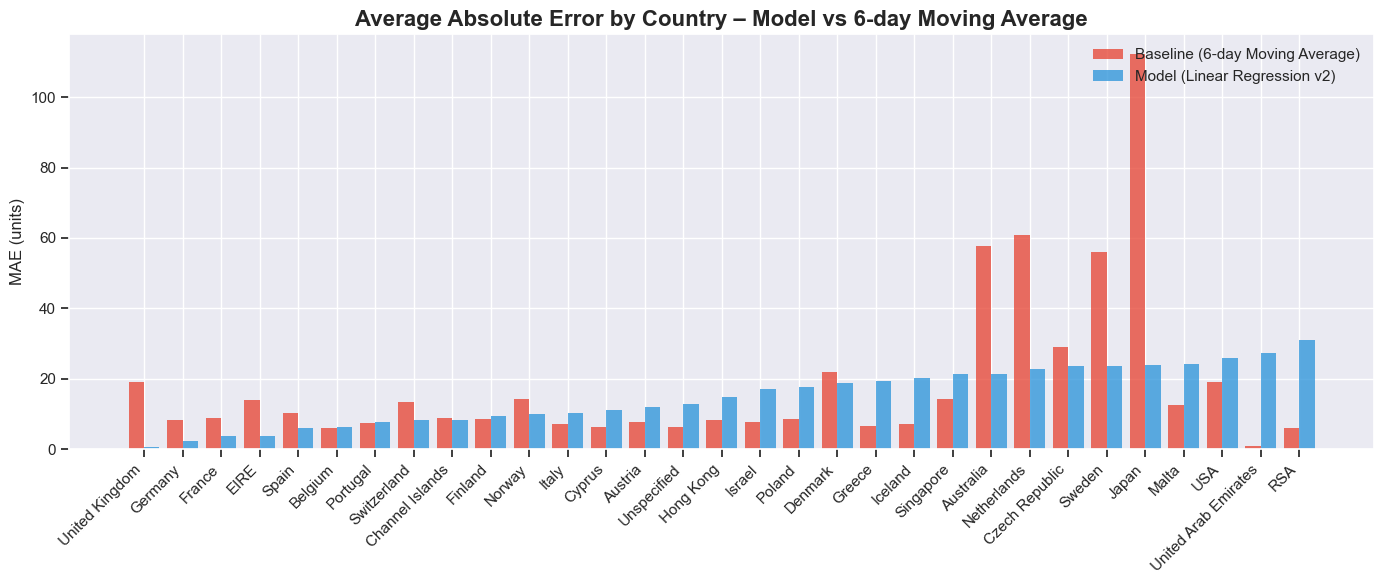

In [32]:
# Bar plot of MAE by Country: Model (LR v2) vs 6-day Moving Average baseline

# X-axis: list of countries
x = kpi_by_country_pdf["Country"].tolist()

# Positions of the bars on the X-axis
indices = list(range(len(x)))
bar_width = 0.4

plt.figure(figsize=(14, 6))

# Baseline MAE (6-day moving average)
plt.bar(
    [i - bar_width / 2 for i in indices],
    kpi_by_country_pdf["MAE_baseline"],
    width=bar_width,
    label="Baseline (6-day Moving Average)",
    alpha=0.8,
    color="#E74C3C"
)

# Model MAE (Linear Regression v2)
plt.bar(
    [i + bar_width / 2 for i in indices],
    kpi_by_country_pdf["MAE_model"],
    width=bar_width,
    label="Model (Linear Regression v2)",
    alpha=0.8,
    color="#3498DB"
)

plt.xticks(indices, x, rotation=45, ha="right")
plt.ylabel("MAE (units)")
plt.title(
    "Average Absolute Error by Country – Model vs 6-day Moving Average",
    fontsize=16,
    fontweight="bold"
)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("mae_by_country.png", dpi=300, bbox_inches="tight")
plt.show()

### Interpretation of the results by country

The MAE-by-country chart shows that the **Linear Regression v2 model** performed **excellent for the United Kingdom**, which concentrates most of the sales volume. In this region:

- The **model’s MAE** is much lower than the **baseline MAE** (moving average),
- Indicating that the model is capturing demand patterns well when there is **plenty of historical data**.

On the other hand, for several **other countries with lower sales volume**, the behavior is different:

- The **model’s MAE** is sometimes **similar to** or even **worse than** the baseline,
- Suggesting that where there is **little history or very sparse series**, the global model cannot learn stable patterns.

### Possible improvement

One strategy to improve these cases would be to:

- **Train separate models by country group**, for example:
  - A specific model for the **United Kingdom** (largest volume),
  - One model for countries with **intermediate volume**,
  - And another one (or even a simple baseline) for countries with **very low volume**.

This way, each model is optimized for the **data reality** of that group, instead of a single global model trying to adapt to all countries at once.

In [33]:
# Train separate Linear Regression models:
# - One for the United Kingdom
# - One for all other countries
# using the v3 feature set (lags + rolling features)

# Split dataset into UK vs other countries
df_uk = daily_sales_v3.filter(F.col("Country") == "United Kingdom")
df_other = daily_sales_v3.filter(F.col("Country") != "United Kingdom")

# Train/test split for each group using the same time cutoff
train_uk = df_uk.filter(F.col("InvoiceDate") <= split_date)
test_uk = df_uk.filter(F.col("InvoiceDate") > split_date)

train_ot = df_other.filter(F.col("InvoiceDate") <= split_date)
test_ot = df_other.filter(F.col("InvoiceDate") > split_date)

print("UK     -> train:", train_uk.count(), " | test:", test_uk.count())
print("Others -> train:", train_ot.count(), " | test:", test_ot.count())

# Fit feature pipeline separately for each group and transform
prep_model_uk = pipeline_features_v3.fit(train_uk)
train_uk_prep = prep_model_uk.transform(train_uk)
test_uk_prep = prep_model_uk.transform(test_uk)

prep_model_ot = pipeline_features_v3.fit(train_ot)
train_ot_prep = prep_model_ot.transform(train_ot)
test_ot_prep = prep_model_ot.transform(test_ot)

# Helper: train and evaluate a Linear Regression model (same hyperparameters as LR v2)
def train_and_eval_lr(name, train_df, test_df):
    lr = LinearRegression(
        featuresCol="features",
        labelCol="NetDailyQuantity",
        predictionCol="prediction",
        maxIter=20,
        regParam=0.05,
        elasticNetParam=1.0,  # Lasso
        standardization=True,
        fitIntercept=True
    )

    print(f"\nTraining Linear Regression ({name})...")
    lr_model = lr.fit(train_df)

    pred = lr_model.transform(test_df)

    evaluator_mae = RegressionEvaluator(
        labelCol="NetDailyQuantity",
        predictionCol="prediction",
        metricName="mae"
    )
    evaluator_rmse = RegressionEvaluator(
        labelCol="NetDailyQuantity",
        predictionCol="prediction",
        metricName="rmse"
    )
    evaluator_r2 = RegressionEvaluator(
        labelCol="NetDailyQuantity",
        predictionCol="prediction",
        metricName="r2"
    )

    mae = evaluator_mae.evaluate(pred)
    rmse = evaluator_rmse.evaluate(pred)
    r2 = evaluator_r2.evaluate(pred)

    print(f"Linear Regression {name} - Test Performance")
    print(f"MAE : {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²  : {r2:.4f}")

    return pred, (mae, rmse, r2)

# Train and evaluate the country-specific models
pred_uk, (mae_uk, rmse_uk, r2_uk) = train_and_eval_lr("UK", train_uk_prep, test_uk_prep)
pred_ot, (mae_ot, rmse_ot, r2_ot) = train_and_eval_lr("Others", train_ot_prep, test_ot_prep)

print("\n" + "="*26)
print("COUNTRY-SPECIFIC MODELS")
print("="*26)
print(f"United Kingdom : MAE = {mae_uk:.2f} | RMSE = {rmse_uk:.2f} | R² = {r2_uk:.4f}")
print(f"Other countries: MAE = {mae_ot:.2f} | RMSE = {rmse_ot:.2f} | R² = {r2_ot:.4f}")

UK     -> train: 170079  | test: 95337
Others -> train: 26937  | test: 17662

Training Linear Regression (UK)...
Linear Regression UK - Test Performance
MAE : 0.51
RMSE: 11.21
R²  : 0.9790

Training Linear Regression (Others)...
Linear Regression Others - Test Performance
MAE : 7.09
RMSE: 22.90
R²  : 0.7734

COUNTRY-SPECIFIC MODELS
United Kingdom : MAE = 0.51 | RMSE = 11.21 | R² = 0.9790
Other countries: MAE = 7.09 | RMSE = 22.90 | R² = 0.7734


In [34]:
# Evaluate segmented Linear Regression models (UK vs Others)
# against the same 6-day moving-average baseline

# Build evaluation DataFrame for UK model
eval_df_uk = (
    pred_uk
    .select(
        "Country",
        "StockCode",
        "InvoiceDate",
        "NetDailyQuantity",
        "NetDailyRevenue",
        "AvgUnitPrice",
        "prediction"
    )
    .join(
        daily_with_ma.select(
            "Country",
            "StockCode",
            "InvoiceDate",
            "baseline_qty"
        ),
        on=["Country", "StockCode", "InvoiceDate"],
        how="left"
    )
)

# Build evaluation DataFrame for Other countries model
eval_df_ot = (
    pred_ot
    .select(
        "Country",
        "StockCode",
        "InvoiceDate",
        "NetDailyQuantity",
        "NetDailyRevenue",
        "AvgUnitPrice",
        "prediction"
    )
    .join(
        daily_with_ma.select(
            "Country",
            "StockCode",
            "InvoiceDate",
            "baseline_qty"
        ),
        on=["Country", "StockCode", "InvoiceDate"],
        how="left"
    )
)

# Combine both evaluation DataFrames
eval_df_new = eval_df_uk.unionByName(eval_df_ot)

# Replace null baseline values with 0 (same rule as before)
eval_df_new = eval_df_new.withColumn(
    "baseline_qty",
    F.coalesce(F.col("baseline_qty"), F.lit(0.0))
)

# Recompute errors and percentage errors
eval_kpi_new = (
    eval_df_new
    .withColumn("err_model",    F.col("prediction")   - F.col("NetDailyQuantity"))
    .withColumn("err_baseline", F.col("baseline_qty") - F.col("NetDailyQuantity"))
    .withColumn("abs_err_model",    F.abs("err_model"))
    .withColumn("abs_err_baseline", F.abs("err_baseline"))
    .withColumn("ape_model",    F.col("abs_err_model")    / F.col("NetDailyQuantity"))
    .withColumn("ape_baseline", F.col("abs_err_baseline") / F.col("NetDailyQuantity"))
)

# KPIs by Country using segmented models (UK vs Others)
kpi_by_country_new = (
    eval_kpi_new
    .groupBy("Country")
    .agg(
        F.avg("abs_err_model").alias("MAE_model"),
        F.avg("abs_err_baseline").alias("MAE_baseline"),
        F.avg("ape_model").alias("MAPE_model"),
        F.avg("ape_baseline").alias("MAPE_baseline"),
        F.avg("err_model").alias("Bias_model"),
        F.avg("err_baseline").alias("Bias_baseline")
    )
    .orderBy("Country")
)

kpi_by_country_new_pdf = (
    kpi_by_country_new
    .toPandas()
    .sort_values("MAE_model", ascending=True)
    .reset_index(drop=True)
)

print("KPIs by Country with segmented Linear Regression models (UK vs Others):")
kpi_by_country_new_pdf.head(30)

KPIs by Country with segmented Linear Regression models (UK vs Others):


,Country,MAE_model,MAE_baseline,MAPE_model,MAPE_baseline,Bias_model,Bias_baseline
0,United Kingdom,0.512376,18.947520,0.113636,2.793290,-0.111918,-0.207976
1,Germany,3.825774,8.229360,0.481771,0.407564,1.499274,-1.677706
2,France,4.290080,8.823614,0.769170,0.755983,2.250543,-0.370824
3,Belgium,4.753677,6.104309,0.745098,0.417012,2.730166,-3.328562
4,EIRE,5.516849,13.971330,0.651644,0.842754,1.895406,-1.159660
5,Spain,6.363326,10.214819,1.257053,0.928576,1.655567,-2.436887
6,Finland,7.032123,8.627730,1.524106,0.729717,4.380821,-5.574569
7,Channel Islands,7.205053,8.737617,1.062429,0.631961,4.568481,-4.836680
8,Portugal,7.221524,7.396996,1.960738,1.328390,5.299877,-3.365761
9,Switzerland,7.298932,13.369835,0.882537,0.989353,0.964810,-6.530460


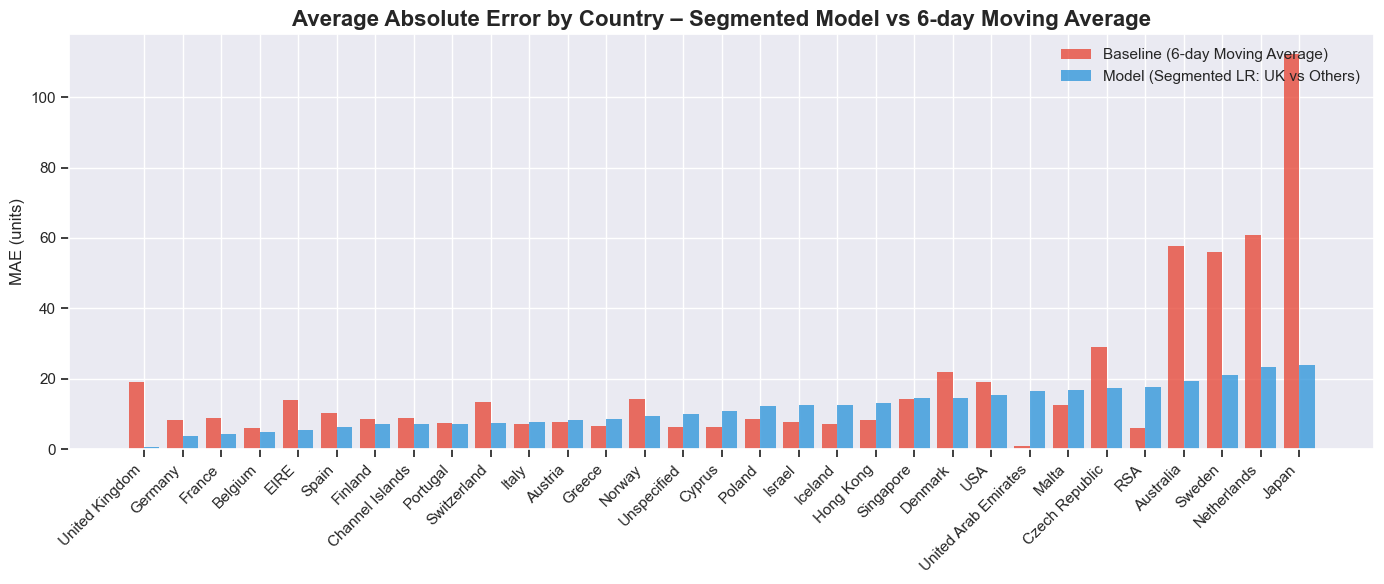

In [35]:
# Bar plot of MAE by Country: Segmented LR models (UK vs Others) vs 6-day Moving Average baseline

# X-axis: list of countries
x = kpi_by_country_new_pdf["Country"].tolist()

# Positions of the bars on the X-axis
indices = list(range(len(x)))
bar_width = 0.4

plt.figure(figsize=(14, 6))

# Baseline MAE (6-day moving average)
plt.bar(
    [i - bar_width / 2 for i in indices],
    kpi_by_country_new_pdf["MAE_baseline"],
    width=bar_width,
    label="Baseline (6-day Moving Average)",
    alpha=0.8,
    color="#E74C3C"
)

# Segmented model MAE (UK vs Others)
plt.bar(
    [i + bar_width / 2 for i in indices],
    kpi_by_country_new_pdf["MAE_model"],
    width=bar_width,
    label="Model (Segmented LR: UK vs Others)",
    alpha=0.8,
    color="#3498DB"
)

plt.xticks(indices, x, rotation=45, ha="right")
plt.ylabel("MAE (units)")
plt.title(
    "Average Absolute Error by Country – Segmented Model vs 6-day Moving Average",
    fontsize=16,
    fontweight="bold"
)
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig("mae_by_country_segmented.png", dpi=300, bbox_inches="tight")
plt.show()

In [36]:
# Compare MAE performance by Country:
# - Global LR v2 model (trained on all countries)
# - Segmented LR models (UK vs Others)
# both against the same 6-day moving-average baseline

# Convert KPIs to Pandas for comparison
kpi_before_pdf = (
    kpi_by_country
    .select(
        "Country",
        F.col("MAE_model").alias("MAE_model_global"),
        F.col("MAE_baseline").alias("MAE_baseline")
    )
    .toPandas()
)

kpi_after_pdf = (
    kpi_by_country_new
    .select(
        "Country",
        F.col("MAE_model").alias("MAE_model_split")
    )
    .toPandas()
)

# Merge and calculate differences
kpi_compare_pdf = kpi_before_pdf.merge(kpi_after_pdf, on="Country", how="inner")

# Delta MAE (negative = improvement)
kpi_compare_pdf["delta_MAE_model"] = (
    kpi_compare_pdf["MAE_model_split"] - kpi_compare_pdf["MAE_model_global"]
)

# Distance from model to baseline (before and after)
kpi_compare_pdf["diff_global_vs_baseline"] = (
    kpi_compare_pdf["MAE_model_global"] - kpi_compare_pdf["MAE_baseline"]
)
kpi_compare_pdf["diff_split_vs_baseline"] = (
    kpi_compare_pdf["MAE_model_split"] - kpi_compare_pdf["MAE_baseline"]
)

# Flags for improvement and baseline comparison
kpi_compare_pdf["improved_MAE"] = (
    kpi_compare_pdf["MAE_model_split"] < kpi_compare_pdf["MAE_model_global"]
)
kpi_compare_pdf["model_global_better_than_baseline"] = (
    kpi_compare_pdf["MAE_model_global"] < kpi_compare_pdf["MAE_baseline"]
)
kpi_compare_pdf["model_split_better_than_baseline"] = (
    kpi_compare_pdf["MAE_model_split"] < kpi_compare_pdf["MAE_baseline"]
)

# Sort by segmented model MAE (ascending)
kpi_compare_pdf = kpi_compare_pdf.sort_values("MAE_model_split").reset_index(drop=True)

print("=" * 100)
print("MAE by Country – BEFORE vs AFTER segmentation (sorted by MAE_model_split)")
print("=" * 100)
print(kpi_compare_pdf.to_string(index=False))

# Aggregate summary
num_countries = len(kpi_compare_pdf)
countries_MAE_improved = kpi_compare_pdf["improved_MAE"].sum()
countries_MAE_not_improved = num_countries - countries_MAE_improved

before_better_than_baseline = kpi_compare_pdf["model_global_better_than_baseline"].sum()
before_not_better_than_baseline = num_countries - before_better_than_baseline

after_better_than_baseline = kpi_compare_pdf["model_split_better_than_baseline"].sum()
after_not_better_than_baseline = num_countries - after_better_than_baseline

print("\n" + "=" * 100)
print("AGGREGATE SUMMARY OF IMPROVEMENT BY COUNTRY")
print("=" * 100)
print(f"Total countries: {num_countries}")
print(f"\nMAE improvement after segmentation:")
print(f"  • Countries improved:     {countries_MAE_improved}")
print(f"  • Countries not improved: {countries_MAE_not_improved}")
print(f"\nModel vs Baseline BEFORE segmentation:")
print(f"  • Better than baseline:   {before_better_than_baseline}")
print(f"  • Worse than baseline:    {before_not_better_than_baseline}")
print(f"\nModel vs Baseline AFTER segmentation:")
print(f"  • Better than baseline:   {after_better_than_baseline}")
print(f"  • Worse than baseline:    {after_not_better_than_baseline}")
print("=" * 100)

MAE by Country – BEFORE vs AFTER segmentation (sorted by MAE_model_split)
             Country  MAE_model_global  MAE_baseline  MAE_model_split  delta_MAE_model  diff_global_vs_baseline  diff_split_vs_baseline  improved_MAE  model_global_better_than_baseline  model_split_better_than_baseline
      United Kingdom          0.485525     18.947520         0.512376         0.026851               -18.461995              -18.435144         False                               True                              True
             Germany          2.225610      8.229360         3.825774         1.600164                -6.003751               -4.403587         False                               True                              True
              France          3.609458      8.823614         4.290080         0.680621                -5.214156               -4.533535         False                               True                              True
             Belgium          6.135305      6.1043

In [37]:
# Evaluate segmented models (UK vs Others) using VALUE-WEIGHTED errors
# Instead of only units, we weight the quantity error by AvgUnitPrice
# to approximate revenue impact of forecast errors.

# Compute value-weighted absolute errors (model vs baseline)
eval_value_new = (
    eval_kpi_new
    .withColumn(
        "unit_value",
        F.coalesce(F.col("AvgUnitPrice"), F.lit(0.0))
    )
    .withColumn(
        "abs_err_value_model",
        F.col("abs_err_model") * F.col("unit_value")
    )
    .withColumn(
        "abs_err_value_baseline",
        F.col("abs_err_baseline") * F.col("unit_value")
    )
)

# Global aggregation (all countries together)
value_agg_new = (
    eval_value_new
    .agg(
        F.sum("abs_err_value_model").alias("Total_abs_error_value_model"),
        F.sum("abs_err_value_baseline").alias("Total_abs_error_value_baseline"),
        F.count(F.lit(1)).alias("Num_rows")
    )
    .withColumn(
        "Error_value_reduction_pct",
        (1 - F.col("Total_abs_error_value_model") /
             F.col("Total_abs_error_value_baseline")) * 100
    )
)

value_agg_new_pdf = value_agg_new.toPandas()
value_agg_new_pdf["Total_abs_error_value_model"] = (
    value_agg_new_pdf["Total_abs_error_value_model"].map("{:.2f}".format)
)
value_agg_new_pdf["Total_abs_error_value_baseline"] = (
    value_agg_new_pdf["Total_abs_error_value_baseline"].map("{:.2f}".format)
)
value_agg_new_pdf["Error_value_reduction_pct"] = (
    value_agg_new_pdf["Error_value_reduction_pct"].map("{:.2f}".format)
)

print("=" * 100)
print("VALUE-WEIGHTED ABSOLUTE ERROR (segmented models: UK vs Others)")
print("=" * 100)
print(value_agg_new_pdf.to_string(index=False))
print("=" * 100)

# Optional: aggregation by Country to see value-weighted error details
value_agg_by_country_new = (
    eval_value_new
    .groupBy("Country")
    .agg(
        F.sum("abs_err_value_model").alias("Total_abs_error_value_model"),
        F.sum("abs_err_value_baseline").alias("Total_abs_error_value_baseline"),
        F.count(F.lit(1)).alias("Num_rows")
    )
    .withColumn(
        "Error_value_reduction_pct",
        (1 - F.col("Total_abs_error_value_model") /
             F.col("Total_abs_error_value_baseline")) * 100
    )
    .orderBy(F.desc("Total_abs_error_value_model"))
)

value_agg_by_country_new_pdf = value_agg_by_country_new.toPandas()

value_agg_by_country_new_pdf["Total_abs_error_value_model"] = (
    value_agg_by_country_new_pdf["Total_abs_error_value_model"].map("{:.2f}".format)
)
value_agg_by_country_new_pdf["Total_abs_error_value_baseline"] = (
    value_agg_by_country_new_pdf["Total_abs_error_value_baseline"].map("{:.2f}".format)
)
value_agg_by_country_new_pdf["Error_value_reduction_pct"] = (
    value_agg_by_country_new_pdf["Error_value_reduction_pct"].map("{:.2f}".format)
)

print("\n" + "=" * 100)
print("VALUE-WEIGHTED ABSOLUTE ERROR BY COUNTRY (sorted by model total error)")
print("=" * 100)
print(value_agg_by_country_new_pdf.to_string(index=False))
print("=" * 100)

VALUE-WEIGHTED ABSOLUTE ERROR (segmented models: UK vs Others)
Total_abs_error_value_model Total_abs_error_value_baseline  Num_rows Error_value_reduction_pct
                  810485.69                     4908743.46    112999                     83.49

VALUE-WEIGHTED ABSOLUTE ERROR BY COUNTRY (sorted by model total error)
             Country Total_abs_error_value_model Total_abs_error_value_baseline  Num_rows Error_value_reduction_pct
      United Kingdom                   179453.42                     4437769.55     95337                     95.96
           Hong Kong                   165360.09                         704.68        37                 -23365.90
                EIRE                    71757.00                       98652.20      3442                     27.26
              France                    63321.26                       64015.37      3596                      1.08
           Singapore                    53559.53                         594.83        33      

In [38]:
# Summary of value-weighted forecast error for SEGMENTED LR models (UK vs Others) vs baseline

row = value_agg_new.collect()[0]

total_err_model = row["Total_abs_error_value_model"]
total_err_baseline = row["Total_abs_error_value_baseline"]
reduction_pct = row["Error_value_reduction_pct"]

print("Estimated total forecast error (value) - Baseline (6-day MA): {:.2f}".format(total_err_baseline))
print("Estimated total forecast error (value) - Model (Segmented LR: UK vs Others): {:.2f}".format(total_err_model))
print("Relative reduction in forecast error value: {:.2f}%".format(reduction_pct))

Estimated total forecast error (value) - Baseline (6-day MA): 4908743.46
Estimated total forecast error (value) - Model (Segmented LR: UK vs Others): 810485.69
Relative reduction in forecast error value: 83.49%


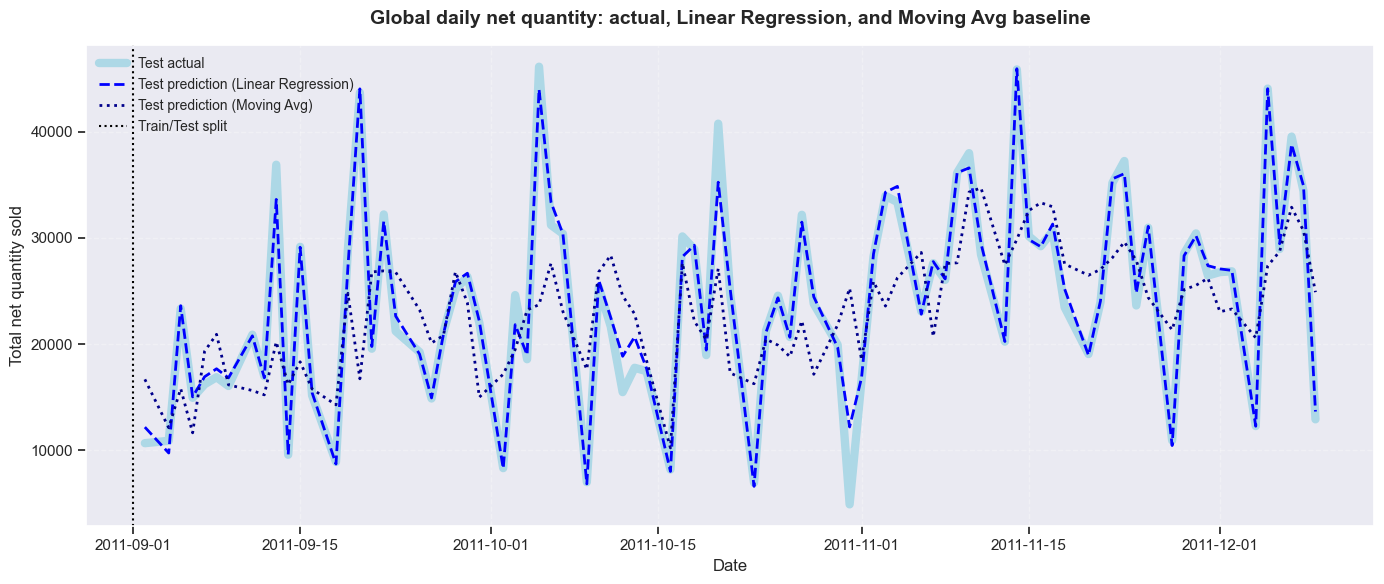

In [39]:
# Build global daily comparison DataFrame: actual vs segmented LR (UK + Others) vs baseline

# Union UK + Others predictions
pred_all = pred_uk.unionByName(pred_ot)

# Aggregate by date: actual, segmented LR prediction, baseline
ts_comparison_lr_split = (
    pred_all
    .join(
        daily_with_ma.select(
            "Country",
            "StockCode",
            "InvoiceDate",
            "baseline_qty"
        ),
        on=["Country", "StockCode", "InvoiceDate"],
        how="left"
    )
    .groupBy("InvoiceDate")
    .agg(
        F.sum("NetDailyQuantity").alias("ActualQty"),
        F.sum("prediction").alias("PredQty_LR_split"),
        F.sum("baseline_qty").alias("PredQty_baseline")
    )
)

# Convert to pandas and sort by date
pdf_lr = ts_comparison_lr_split.orderBy("InvoiceDate").toPandas()
pdf_lr["InvoiceDate"] = pd.to_datetime(pdf_lr["InvoiceDate"])

train_mask = pdf_lr["InvoiceDate"] <= pd.to_datetime(split_date)
test_mask = pdf_lr["InvoiceDate"] > pd.to_datetime(split_date)

plt.figure(figsize=(14, 6))

# Test actual
plt.plot(
    pdf_lr.loc[test_mask, "InvoiceDate"],
    pdf_lr.loc[test_mask, "ActualQty"],
    label="Test actual",
    color="lightblue",
    linewidth=6
)

# Segmented LR predictions (UK vs Others)
plt.plot(
    pdf_lr.loc[test_mask, "InvoiceDate"],
    pdf_lr.loc[test_mask, "PredQty_LR_split"],
    label="Test prediction (Linear Regression)",
    color="blue",
    linestyle="--",
    linewidth=2
)

# 6-day moving average baseline
plt.plot(
    pdf_lr.loc[test_mask, "InvoiceDate"],
    pdf_lr.loc[test_mask, "PredQty_baseline"],
    label="Test prediction (Moving Avg)",
    color="darkblue",
    linestyle=":",
    linewidth=2
)

# Train/test split line
plt.axvline(
    pd.to_datetime(split_date),
    color="black",
    linestyle=":",
    linewidth=1.5,
    label="Train/Test split"
)

plt.title(
    "Global daily net quantity: actual, Linear Regression, and Moving Avg baseline",
    fontsize=14,
    fontweight="bold",
    pad=15
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total net quantity sold", fontsize=12)
plt.legend(fontsize=10, loc="upper left",)
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

Generating Plot 1: Actual vs Predicted (LR v2)...


C:\Users\yuhmo\AppData\Local\Temp\ipykernel_82444\4001927463.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot([0, max_val], [0, max_val], "r--", linewidth=1, label="Ideal line (y=x)", color='blue')


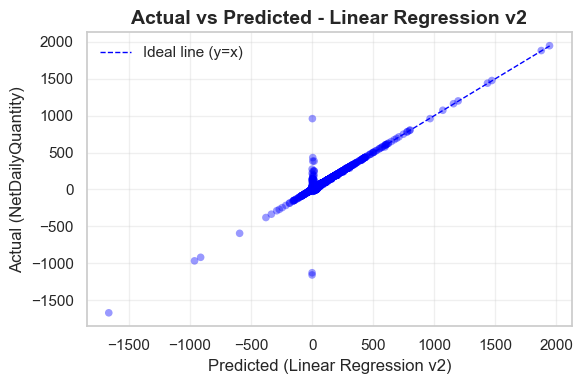

In [40]:
# Style configuration
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100


# SCATTER: ACTUAL vs PREDICTED (diagonal y = x) - Linear Regression v2

print("Generating Plot 1: Actual vs Predicted (LR v2)...")

pdf_lr = (test_predictions_lr_v2
          .select(col("prediction").alias("y_hat"),
                  col("NetDailyQuantity").alias("y"))
          .sample(fraction=0.2, seed=42)  # 20% of sample
          .toPandas())

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pdf_lr["y_hat"], pdf_lr["y"], alpha=0.4, s=30, edgecolors='none', color='blue')
max_val = max(pdf_lr["y_hat"].max(), pdf_lr["y"].max())
ax.plot([0, max_val], [0, max_val], "r--", linewidth=1, label="Ideal line (y=x)", color='blue')
ax.set_xlabel("Predicted (Linear Regression v2)", fontsize=12)
ax.set_ylabel("Actual (NetDailyQuantity)", fontsize=12)
ax.set_title("Actual vs Predicted - Linear Regression v2", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("plot1_actual_vs_pred_lr.png", dpi=150, bbox_inches='tight')
plt.show()

In [41]:
# Extract feature importance for Linear Regression v2 using the fitted pipeline

# Get the VectorAssembler stage from the fitted pipeline
assembler = None
for stage in prep_model_v3.stages:
    if isinstance(stage, VectorAssembler):
        assembler = stage
        break

if assembler:
    feature_names = assembler.getInputCols()
    coefficients = lr_model_v2.coefficients.toArray()
    intercept = lr_model_v2.intercept

    # Create a Pandas DataFrame for better visualization
    feature_importance_lr = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    # Sort by absolute coefficient value to see most impactful features
    feature_importance_lr['Abs_Coefficient'] = feature_importance_lr['Coefficient'].abs()
    feature_importance_lr = feature_importance_lr.sort_values(
        by='Abs_Coefficient', ascending=False
    ).reset_index(drop=True)

    print("Linear Regression v2 Feature Importance (Coefficients):")
    print(feature_importance_lr.to_string(index=False))
    print(f"\nIntercept: {intercept:.2f}")
else:
    print("VectorAssembler not found in prep_model_v3. Cannot extract feature names.")

Linear Regression v2 Feature Importance (Coefficients):
                 Feature  Coefficient  Abs_Coefficient
                    Year    -2.939848         2.939848
            CountryIndex     0.998049         0.998049
          roll_median_6d     0.191575         0.191575
         roll_median_12d     0.191127         0.191127
     diff_qty_median_12d     0.178870         0.178870
      diff_qty_median_6d     0.178298         0.178298
      diff_qty_median_3d     0.173849         0.173849
           roll_mean_12d     0.165018         0.165018
       diff_qty_mean_12d     0.160824         0.160824
          roll_median_3d     0.159773         0.159773
        diff_qty_mean_6d     0.158914         0.158914
            roll_mean_6d     0.148133         0.148133
               DayOfWeek     0.147952         0.147952
        diff_qty_mean_3d     0.145600         0.145600
            roll_mean_3d     0.100485         0.100485
                   Month    -0.031603         0.031603
      lag

#### Global LR v2 – Feature importance (summary)

- The model is a **Lasso-regularized Linear Regression** (elasticNetParam = 1.0) with **standardized features**.  
- In this setup, the **coefficient magnitudes** (absolute values) act as feature importances: larger magnitude ⇒ stronger impact on predicted demand.

#### Main drivers the model is using

From the ranking of absolute coefficients, the most important groups of features are:

1. **Time trend**
   - The `Year` feature has one of the largest coefficients. It could be a problem and maybe should be removed as feature, since the dataset brings just one month from 2010 compared to 12 month in 2011. 

2. **Country effect**
   - `CountryIndex` has consistent level differences in demand. The model heavily uses country information.

3. **Recent demand level and trend (rolling statistics)**
   - Rolling **medians** and **means** over several recent windows (e.g. 3, 6, 12 days) and their **differences** are among the top features:
     - `roll_median_*d`, `roll_mean_*d`
     - `diff_qty_median_*d`, `diff_qty_mean_*d`
   - The model relies a lot on **recent history** of the series — the current level and short-term trend of demand are very predictive of future quantities.

4. **Weekly pattern**
   - `DayOfWeek` has a relatively large coefficient.
   - There is clear **day-of-week seasonality**; some weekdays systematically have higher or lower demand.

5. **Other calendar features and simple lags**
   - `Month`, `Week`, `Day` and a few short lags (e.g. 1–3 days) have **smaller but non-zero** coefficients.
   - They add some extra signal, but far less than the trend, country, and rolling-window features.

6. **Many engineered lag/price features and rolling stds**
   - A large set of lag-based features (different days/dow/cycle lags), rolling standard deviations, and price lags add no impact on predictions. 

#### How Lasso (L1) impacts these importances

Using Lasso (L1 regularization) strongly shapes what you see:

- **Sparsity / feature selection**
  - Lasso pushes many coefficients **exactly to zero**.  
  - Those zero coefficients correspond to features the model judged as **not adding enough information** beyond the others.
  - This is why many detailed lag/price/variance features end up at 0: they are redundant once the model has the key rolling medians/means, trend, country, and day-of-week.

- **Handling correlated features**
  - When several features are highly correlated (e.g., multiple overlapping rolling windows or many similar lags), Lasso tends to keep **only a subset** of them and set the rest to zero.  
  - So the non-zero features you see are often "representatives" of correlated groups.

- **Interpretability**
  - Because features were standardized, non-zero coefficients are **comparable in magnitude**, making it easier to rank importance.
  - The resulting model is more **interpretable and compact**: you can focus on the handful of non-zero features instead of dozens of engineered ones.

### Project Conclusion, Key Findings, and Next Steps

#### 1. Overall Conclusion

The project demonstrates that a relatively simple modeling approach (linear regression with time-series features and a per-country split between **UK** and **non-UK** data) can substantially outperform a moving-average baseline in forecasting daily sales volumes and value. Despite being a first iteration, the model already delivers **large reductions in forecast error**, especially when measured in monetary terms, and brings clear improvements for most countries.

---

#### 2. Key Findings

##### 2.1. Impact of Splitting the Model by Country (UK vs Others)

- **Total number of countries:** 31  
- **Countries whose MAE improved after the split:** 24  
- **Countries whose MAE did not improve:** 7  

This indicates that **~77% of countries** benefited from the modeling change (country-specific treatment rather than a single global model).

##### 2.2. Model vs Baseline (Before and After Split)

- **Before the split (global model):**
  - Countries where the model was better than the baseline: **14**
  - Countries where the model was worse than the baseline: **17**

- **After the split (UK vs Others):**
  - Countries where the model is better than the baseline: **18**
  - Countries where the model is worse than the baseline: **13**

So, after splitting UK vs Others:

- The **number of countries where the model beats the baseline increased from 14 to 18**,  
- and the **number of underperforming countries decreased from 17 to 13**.

This confirms that a simple segmentation strategy (UK vs non-UK) improves the model’s relative performance across geographies.

##### 2.3. Error in Value Terms (Weighted by Unit Price)

Using `AvgUnitPrice` as a proxy for value per unit, the project compared the **absolute error in monetary terms**:

- **Total absolute error (value) – Baseline:** 4,908,743.46  
- **Total absolute error (value) – Split models:** 810,485.53  

This corresponds to an **error reduction of ~83%** in monetary terms when moving from the baseline to the split linear models.

##### 2.4. Country-Level Value Error

At the country level, performance is heterogeneous:

- **United Kingdom** (by far the largest contributor in number of rows) shows:
  - Very large reduction in value-weighted erro.
  - This is the main driver of the strong global improvement.

- Some smaller markets show **negative impact** (model worse than baseline in value terms), e.g.:
  - Hong Kong, Singapore, Portugal, Italy, Cyprus, etc., where the `Error_value_reduction_pct` is strongly negative.
  - These cases are typically based on **few observations per country**, making them more sensitive to noise and model misspecification.

Overall, the **global result is dominated by UK**, but the segmentation still helps many non-UK countries in MAE terms. A handful of small markets require targeted handling or different strategies.

---

#### 3. Interpretation

1. **Segmentation matters**  
   Splitting the modeling between **UK and the rest of the world** significantly improves performance vs a single global model. This suggests that **country-specific patterns** (seasonality, product mix, customer behavior) are important enough to justify tailored models.

2. **Baseline is strong but simple**  
   The moving-average baseline is a **reasonable benchmark**, yet the linear regression models, especially when segmented, consistently outperform it in most markets — particularly in **value-weighted error**, which is what matters most from a business perspective.

3. **Long tail of countries is challenging**  
   Several small countries have:
   - Limited data,  
   - Higher volatility,  
   - And, as a result, models that are **less stable** and sometimes worse than the baseline.  

   For those markets, simpler baselines or pooled models (e.g., regional instead of country-level) might be more appropriate.

---

#### 4. Next Steps

- **Finer segmentation**
  - Consider segmenting non-UK countries further (e.g., EU vs non-EU, or by region).
  - For very low-volume countries, consider grouping them together into a **“Rest of World”** model, or using **hierarchical modeling**.

- **Feature engineering**
  - Remove the year from features.
  - Include **calendar effects** such as end-of-month or pre-holiday spikes.


---

#### 5. Summary

The project successfully shows that:

- A simple **linear regression** model with **basic time-series features** can add substantial value over a **moving-average baseline**.
- **Country segmentation** (UK vs Others) leads to **clear improvements**: most countries see lower MAE and the number of markets where the model beats the baseline increases.
- In **monetary terms**, the reduction in total forecast value error is very large, indicating strong potential business impact.

The current solution is a solid **first production-like prototype**. With additional segmentation, richer features, and more advanced models, there is room to further improve performance, especially in smaller or more volatile markets.